# 1.1. Import necessary libraries and moduls

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf
import pathlib
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold

from tensorflow import keras
from tensorflow.keras import Input, layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import callbacks

# 1.2. Create train dataset base

In [2]:
df = pd.DataFrame(columns=['path','label'])

for dirname, _, filenames in os.walk('C:/Users/server/Desktop/fire_dataset/fire_images'):
    for filename in filenames:
        df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))

#loop over non fire images and label them 0
for dirname, _, filenames in os.walk('C:/Users/server/Desktop/fire_dataset/non_fire_images'):
    for filename in filenames:
        df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'non_fire']],columns=['path','label']))

#shuffle the dataset for redistribute the labels
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)


,path,label
0,C:/Users/server/Desktop/fire_dataset/fire_imag...,fire
1,C:/Users/server/Desktop/fire_dataset/fire_imag...,fire
2,C:/Users/server/Desktop/fire_dataset/fire_imag...,fire
3,C:/Users/server/Desktop/fire_dataset/fire_imag...,fire
4,C:/Users/server/Desktop/fire_dataset/non_fire_...,non_fire
5,C:/Users/server/Desktop/fire_dataset/fire_imag...,fire
6,C:/Users/server/Desktop/fire_dataset/fire_imag...,fire
7,C:/Users/server/Desktop/fire_dataset/fire_imag...,fire
8,C:/Users/server/Desktop/fire_dataset/fire_imag...,fire
9,C:/Users/server/Desktop/fire_dataset/fire_imag...,fire


# 1.3. Create test dataset

In [3]:
#create an empty DataFrame for test dataset
df2 = pd.DataFrame(columns=['path','label'])

for dirname, _, filenames in os.walk('C:/Users/server/Desktop/fire_dataset_test/fire_images'):
    for filename in filenames:
        df2 = df2.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))

#loop over non fire images
for dirname, _, filenames in os.walk('C:/Users/server/Desktop/fire_dataset_test/non_fire_images'):
    for filename in filenames:
        df2 = df2.append(pd.DataFrame([[os.path.join(dirname, filename),'non_fire']],columns=['path','label']))


#shuffle the dataset for redistribute the labels
df2 = df2.sample(frac=1).reset_index(drop=True)
df2.head(10)

# make test dataset

test_datagen = image.ImageDataGenerator(rescale = 1./255)

test_ds = test_datagen.flow_from_dataframe(
    dataframe = df2,
    x_col = "path",
    y_col = "label",
    target_size = (250, 250),
    color_mode = "rgb",
    class_mode = "binary",
    shuffle = False)

# test answers
LE = LabelEncoder()
y_test = LE.fit_transform(df2["label"])
print(y_test)


Found 651 validated image filenames belonging to 2 classes.
[1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0
 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1
 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1
 1 1 1 0 0 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1
 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1
 1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0

# 1.4. Class for recording learning time (not used later)

In [4]:
from time import time

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


# 2. 1st experimental setting

Train model with “Forest fire detection dataset” and test it with “General fire detection dataset”.

# 2.1. Own model

Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 7 steps
Epoch 1/5
25/25 [==============================] - 32s 1s/step - loss: 0.3741 - accuracy: 0.8385 - val_loss: 0.2238 - val_accuracy: 0.9200
Epoch 2/5
25/25 [==============================] - 29s 1s/step - loss: 0.1650 - accuracy: 0.9399 - val_loss: 0.1928 - val_accuracy: 0.9450
Epoch 3/5
25/25 [==============================] - 29s 1s/step - loss: 0.1615 - accuracy: 0.9387 - val_loss: 0.2104 - val_accuracy: 0.9400
Epoch 4/5
25/25 [==============================] - 29s 1s/step - loss: 0.1055 - accuracy: 0.9599 - val_loss: 0.1838 - val_accuracy: 0.9600
Epoch 5/5
25/25 [==============================] - 28s 1s/step - loss: 0.1050 - accuracy: 0.9599 - val_loss: 0.2513 - val_accuracy: 0.9500
  ...
    to  
  ['...']
21/21 [==============================] - 7s 334ms/step - loss: 1.9330

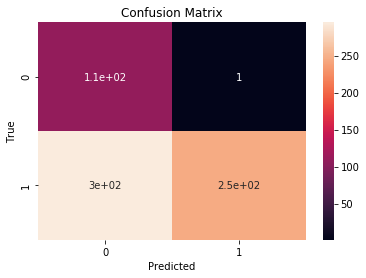

In [5]:
# Option 1

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_own = []
val_losses_own = []

test_accs_own = []
test_losses_own = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

for train_index, val_index in skf.split(df, df['label']):
  
  # for time efficiency, we train only once now
  if num_model == 2:
    break
  
  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()

  #callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs#,
    #callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)
  
  model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_own.append(score[1])
  test_losses_own.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 7 steps
Epoch 1/10
25/25 [==============================] - 29s 1s/step - loss: 0.4468 - accuracy: 0.7697 - val_loss: 0.2175 - val_accuracy: 0.9050
Epoch 2/10
25/25 [==============================] - 30s 1s/step - loss: 0.1831 - accuracy: 0.9237 - val_loss: 0.1415 - val_accuracy: 0.9350
Epoch 3/10
25/25 [==============================] - 31s 1s/step - loss: 0.1257 - accuracy: 0.9562 - val_loss: 0.1364 - val_accuracy: 0.9400
Epoch 4/10
25/25 [==============================] - 29s 1s/step - loss: 0.1267 - accuracy: 0.9524 - val_loss: 0.1020 - val_accuracy: 0.9500
Epoch 5/10
25/25 [==============================] - 28s 1s/step - loss: 0.1093 - accuracy: 0.9650 - val_loss: 0.2514 - val_accuracy: 0.9050
Epoch 6/10
25/25 [==============================] - 28s 1s/step - loss: 0.1456 - accuracy

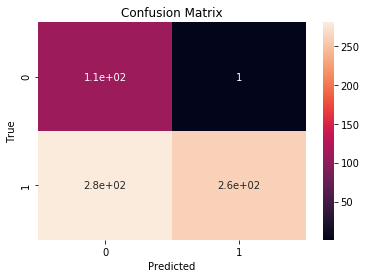

In [6]:
# Option 2

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_own = []
val_losses_own = []

test_accs_own = []
test_losses_own = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

for train_index, val_index in skf.split(df, df['label']):
  
  # for time efficiency, we train only once now
  if num_model == 2:
    break
  
  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()

  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)
  
  model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_own.append(score[1])
  test_losses_own.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/5
8/8 [==============================] - 28s 4s/step - loss: 0.7776 - accuracy: 0.6971 - val_loss: 0.4867 - val_accuracy: 0.7550
Epoch 2/5
8/8 [==============================] - 28s 4s/step - loss: 0.4045 - accuracy: 0.8048 - val_loss: 0.2963 - val_accuracy: 0.8750
Epoch 3/5
8/8 [==============================] - 28s 3s/step - loss: 0.2695 - accuracy: 0.8999 - val_loss: 0.2153 - val_accuracy: 0.9250
Epoch 4/5
8/8 [==============================] - 28s 3s/step - loss: 0.1790 - accuracy: 0.9462 - val_loss: 0.1539 - val_accuracy: 0.9350
Epoch 5/5
8/8 [==============================] - 28s 3s/step - loss: 0.1576 - accuracy: 0.9424 - val_loss: 0.1515 - val_accuracy: 0.9550
  ...
    to  
  ['...']
21/21 [==============================] - 6s 294ms/step - loss: 3.5671 - accuracy

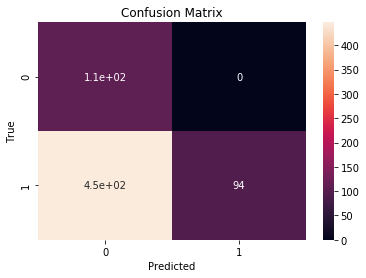

In [7]:
# Option 3

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_own = []
val_losses_own = []

test_accs_own = []
test_losses_own = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

for train_index, val_index in skf.split(df, df['label']):
  
  # for time efficiency, we train only once now
  if num_model == 2:
    break
  
  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()

  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)
  
  model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_own.append(score[1])
  test_losses_own.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/20
8/8 [==============================] - 28s 3s/step - loss: 0.7117 - accuracy: 0.7397 - val_loss: 0.3858 - val_accuracy: 0.7550
Epoch 2/20
8/8 [==============================] - 28s 3s/step - loss: 0.3622 - accuracy: 0.7972 - val_loss: 0.3350 - val_accuracy: 0.8900
Epoch 3/20
8/8 [==============================] - 27s 3s/step - loss: 0.2105 - accuracy: 0.9487 - val_loss: 0.3541 - val_accuracy: 0.8950
Epoch 4/20
8/8 [==============================] - 28s 3s/step - loss: 0.1450 - accuracy: 0.9462 - val_loss: 0.1689 - val_accuracy: 0.9150
Epoch 5/20
8/8 [==============================] - 28s 3s/step - loss: 0.1102 - accuracy: 0.9537 - val_loss: 0.2377 - val_accuracy: 0.9000
Epoch 6/20
8/8 [==============================] - 27s 3s/step - loss: 0.1071 - accuracy: 0.9574 - va

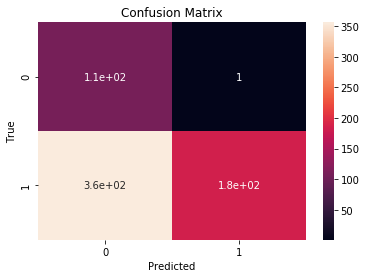

In [8]:
# Option 4

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_own = []
val_losses_own = []

test_accs_own = []
test_losses_own = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

for train_index, val_index in skf.split(df, df['label']):
  
  # for time efficiency, we train only once now
  if num_model == 2:
    break
  
  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()

  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=20
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)
  
  model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_own.append(score[1])
  test_losses_own.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 7 steps
Epoch 1/10
25/25 [==============================] - 28s 1s/step - loss: 0.3746 - accuracy: 0.8723 - val_loss: 0.1217 - val_accuracy: 0.9500
Epoch 2/10
25/25 [==============================] - 28s 1s/step - loss: 0.1606 - accuracy: 0.9387 - val_loss: 0.1528 - val_accuracy: 0.9550
Epoch 3/10
25/25 [==============================] - 28s 1s/step - loss: 0.1062 - accuracy: 0.9662 - val_loss: 0.1371 - val_accuracy: 0.9350
Epoch 4/10
25/25 [==============================] - 28s 1s/step - loss: 0.1026 - accuracy: 0.9625 - val_loss: 0.1604 - val_accuracy: 0.9550
Epoch 5/10
25/25 [==============================] - 27s 1s/step - loss: 0.1009 - accuracy: 0.9637 - val_loss: 0.1468 - val_accuracy: 0.9650
Epoch 6/10
25/25 [==============================] - 28s 1s/step - loss: 0.0877 - accuracy

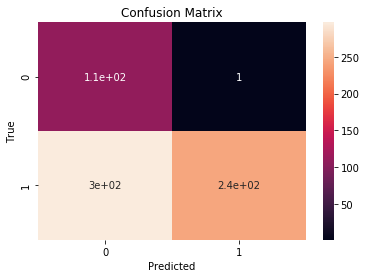

In [9]:
# Option 5

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_own = []
val_losses_own = []

test_accs_own = []
test_losses_own = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

for train_index, val_index in skf.split(df, df['label']):
  
  # for time efficiency, we train only once now
  if num_model == 2:
    break
  
  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()

  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)
  
  model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_own.append(score[1])
  test_losses_own.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/5
8/8 [==============================] - 28s 3s/step - loss: 0.5752 - accuracy: 0.7747 - val_loss: 0.4381 - val_accuracy: 0.8000
Epoch 2/5
8/8 [==============================] - 28s 3s/step - loss: 0.2546 - accuracy: 0.9086 - val_loss: 0.2143 - val_accuracy: 0.9000
Epoch 3/5
8/8 [==============================] - 27s 3s/step - loss: 0.1793 - accuracy: 0.9274 - val_loss: 0.3104 - val_accuracy: 0.8500
Epoch 4/5
8/8 [==============================] - 27s 3s/step - loss: 0.1599 - accuracy: 0.9437 - val_loss: 0.2553 - val_accuracy: 0.8950
Epoch 5/5
8/8 [==============================] - 28s 3s/step - loss: 0.1402 - accuracy: 0.9449 - val_loss: 0.1615 - val_accuracy: 0.9300
  ...
    to  
  ['...']
21/21 [==============================] - 6s 293ms/step - loss: 2.0045 - accuracy

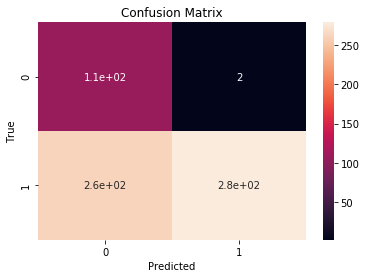

In [10]:
# Option 6

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_own = []
val_losses_own = []

test_accs_own = []
test_losses_own = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

for train_index, val_index in skf.split(df, df['label']):
  
  # for time efficiency, we train only once now
  if num_model == 2:
    break
  
  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()

  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)
  
  model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_own.append(score[1])
  test_losses_own.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/20
8/8 [==============================] - 28s 3s/step - loss: 0.6367 - accuracy: 0.7447 - val_loss: 0.3710 - val_accuracy: 0.8550
Epoch 2/20
8/8 [==============================] - 28s 3s/step - loss: 0.2794 - accuracy: 0.9049 - val_loss: 0.2265 - val_accuracy: 0.9000
Epoch 3/20
8/8 [==============================] - 28s 3s/step - loss: 0.1404 - accuracy: 0.9487 - val_loss: 0.1783 - val_accuracy: 0.9400
Epoch 4/20
8/8 [==============================] - 27s 3s/step - loss: 0.1211 - accuracy: 0.9499 - val_loss: 0.2924 - val_accuracy: 0.8900
Epoch 5/20
8/8 [==============================] - 27s 3s/step - loss: 0.1148 - accuracy: 0.9537 - val_loss: 0.1849 - val_accuracy: 0.9150
Epoch 6/20
8/8 [==============================] - 27s 3s/step - loss: 0.0981 - accuracy: 0.9662 - va

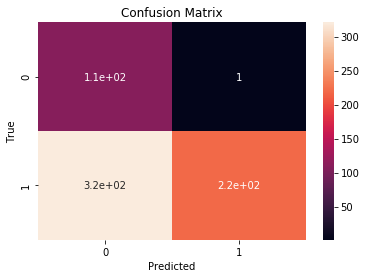

In [11]:
# Option 7

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_own = []
val_losses_own = []

test_accs_own = []
test_losses_own = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

for train_index, val_index in skf.split(df, df['label']):
  
  # for time efficiency, we train only once now
  if num_model == 2:
    break
  
  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()

  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=20
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)
  
  model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_own.append(score[1])
  test_losses_own.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 7 steps
Epoch 1/5
25/25 [==============================] - 28s 1s/step - loss: 0.3656 - accuracy: 0.8373 - val_loss: 0.2352 - val_accuracy: 0.8900
Epoch 2/5
25/25 [==============================] - 28s 1s/step - loss: 0.1663 - accuracy: 0.9449 - val_loss: 0.1294 - val_accuracy: 0.9550
Epoch 3/5
25/25 [==============================] - 28s 1s/step - loss: 0.1290 - accuracy: 0.9512 - val_loss: 0.1294 - val_accuracy: 0.9650
Epoch 4/5
25/25 [==============================] - 29s 1s/step - loss: 0.1092 - accuracy: 0.9637 - val_loss: 0.1393 - val_accuracy: 0.9550
Epoch 5/5
25/25 [==============================] - 28s 1s/step - loss: 0.1185 - accuracy: 0.9537 - val_loss: 0.1165 - val_accuracy: 0.9650
  ...
    to  
  ['...']
21/21 [==============================] - 6s 295ms/step - loss: 1.1288

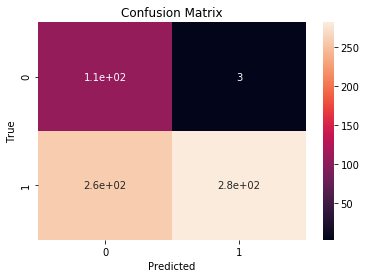

In [12]:
# Option 8

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_own = []
val_losses_own = []

test_accs_own = []
test_losses_own = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

for train_index, val_index in skf.split(df, df['label']):
  
  # for time efficiency, we train only once now
  if num_model == 2:
    break
  
  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()

  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)
  
  model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_own.append(score[1])
  test_losses_own.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 7 steps
Epoch 1/10
25/25 [==============================] - 29s 1s/step - loss: 0.3255 - accuracy: 0.8573 - val_loss: 0.1509 - val_accuracy: 0.9650
Epoch 2/10
25/25 [==============================] - 28s 1s/step - loss: 0.2001 - accuracy: 0.9287 - val_loss: 0.1491 - val_accuracy: 0.9350
Epoch 3/10
25/25 [==============================] - 28s 1s/step - loss: 0.1540 - accuracy: 0.9449 - val_loss: 0.1390 - val_accuracy: 0.9450
Epoch 4/10
25/25 [==============================] - 28s 1s/step - loss: 0.1391 - accuracy: 0.9524 - val_loss: 0.1262 - val_accuracy: 0.9500
Epoch 5/10
25/25 [==============================] - 28s 1s/step - loss: 0.1558 - accuracy: 0.9462 - val_loss: 0.1053 - val_accuracy: 0.9700
Epoch 6/10
25/25 [==============================] - 28s 1s/step - loss: 0.1546 - accuracy

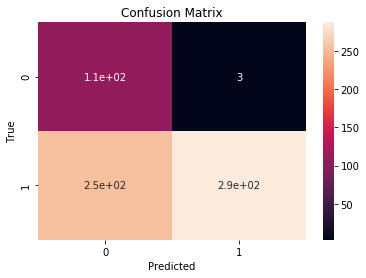

In [13]:
# Option 9

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_own = []
val_losses_own = []

test_accs_own = []
test_losses_own = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

for train_index, val_index in skf.split(df, df['label']):
  
  # for time efficiency, we train only once now
  if num_model == 2:
    break
  
  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()

  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)
  
  model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_own.append(score[1])
  test_losses_own.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/5
8/8 [==============================] - 28s 4s/step - loss: 0.6735 - accuracy: 0.7910 - val_loss: 0.3685 - val_accuracy: 0.9100
Epoch 2/5
8/8 [==============================] - 29s 4s/step - loss: 0.2671 - accuracy: 0.8961 - val_loss: 0.1722 - val_accuracy: 0.9350
Epoch 3/5
8/8 [==============================] - 28s 4s/step - loss: 0.1473 - accuracy: 0.9462 - val_loss: 0.1481 - val_accuracy: 0.9400
Epoch 4/5
8/8 [==============================] - 28s 4s/step - loss: 0.1473 - accuracy: 0.9499 - val_loss: 0.1426 - val_accuracy: 0.9450
Epoch 5/5
8/8 [==============================] - 28s 3s/step - loss: 0.1407 - accuracy: 0.9499 - val_loss: 0.1521 - val_accuracy: 0.9500
  ...
    to  
  ['...']
21/21 [==============================] - 6s 291ms/step - loss: 1.6064 - accuracy

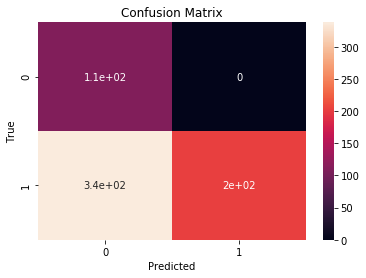

In [14]:
# Option 10

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_own = []
val_losses_own = []

test_accs_own = []
test_losses_own = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

for train_index, val_index in skf.split(df, df['label']):
  
  # for time efficiency, we train only once now
  if num_model == 2:
    break
  
  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()

  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)
  
  model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_own.append(score[1])
  test_losses_own.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/20
8/8 [==============================] - 28s 3s/step - loss: 0.5045 - accuracy: 0.7697 - val_loss: 0.3182 - val_accuracy: 0.8700
Epoch 2/20
8/8 [==============================] - 28s 3s/step - loss: 0.3160 - accuracy: 0.8436 - val_loss: 0.2923 - val_accuracy: 0.8950
Epoch 3/20
8/8 [==============================] - 28s 3s/step - loss: 0.2526 - accuracy: 0.8936 - val_loss: 0.2126 - val_accuracy: 0.9050
Epoch 4/20
8/8 [==============================] - 28s 3s/step - loss: 0.1773 - accuracy: 0.9349 - val_loss: 0.2557 - val_accuracy: 0.8950
Epoch 5/20
8/8 [==============================] - 28s 3s/step - loss: 0.1496 - accuracy: 0.9537 - val_loss: 0.1640 - val_accuracy: 0.9350
Epoch 6/20
8/8 [==============================] - 28s 4s/step - loss: 0.1301 - accuracy: 0.9599 - va

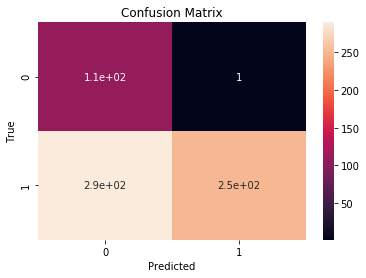

In [15]:
# Option 11

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_own = []
val_losses_own = []

test_accs_own = []
test_losses_own = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

for train_index, val_index in skf.split(df, df['label']):
  
  # for time efficiency, we train only once now
  if num_model == 2:
    break
  
  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()

  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=20
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)
  
  model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_own.append(score[1])
  test_losses_own.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 7 steps
Epoch 1/10
25/25 [==============================] - 28s 1s/step - loss: 0.4815 - accuracy: 0.8123 - val_loss: 0.2205 - val_accuracy: 0.8900
Epoch 2/10
25/25 [==============================] - 28s 1s/step - loss: 0.1831 - accuracy: 0.9324 - val_loss: 0.2640 - val_accuracy: 0.9250
Epoch 3/10
25/25 [==============================] - 29s 1s/step - loss: 0.1618 - accuracy: 0.9387 - val_loss: 0.1381 - val_accuracy: 0.9350
Epoch 4/10
25/25 [==============================] - 29s 1s/step - loss: 0.1123 - accuracy: 0.9625 - val_loss: 0.1334 - val_accuracy: 0.9500
Epoch 5/10
25/25 [==============================] - 29s 1s/step - loss: 0.1097 - accuracy: 0.9599 - val_loss: 0.1279 - val_accuracy: 0.9300
Epoch 6/10
25/25 [==============================] - 29s 1s/step - loss: 0.1120 - accuracy

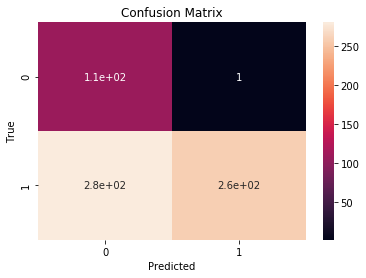

In [16]:
# Option 12

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_own = []
val_losses_own = []

test_accs_own = []
test_losses_own = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

for train_index, val_index in skf.split(df, df['label']):
  
  # for time efficiency, we train only once now
  if num_model == 2:
    break
  
  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()

  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)
  
  model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_own.append(score[1])
  test_losses_own.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/5
8/8 [==============================] - 28s 3s/step - loss: 0.8824 - accuracy: 0.7059 - val_loss: 0.4776 - val_accuracy: 0.7600
Epoch 2/5
8/8 [==============================] - 28s 3s/step - loss: 0.3827 - accuracy: 0.8085 - val_loss: 0.3861 - val_accuracy: 0.8100
Epoch 3/5
8/8 [==============================] - 28s 4s/step - loss: 0.2558 - accuracy: 0.8899 - val_loss: 0.1612 - val_accuracy: 0.9350
Epoch 4/5
8/8 [==============================] - 28s 3s/step - loss: 0.1936 - accuracy: 0.9224 - val_loss: 0.1584 - val_accuracy: 0.9450
Epoch 5/5
8/8 [==============================] - 28s 3s/step - loss: 0.1772 - accuracy: 0.9299 - val_loss: 0.1458 - val_accuracy: 0.9350
  ...
    to  
  ['...']
21/21 [==============================] - 6s 296ms/step - loss: 1.7966 - accuracy

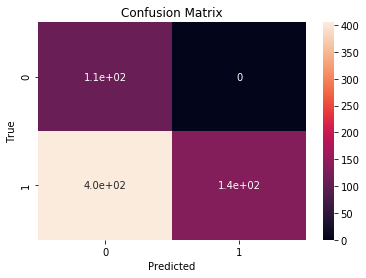

In [17]:
# Option 13

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_own = []
val_losses_own = []

test_accs_own = []
test_losses_own = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

for train_index, val_index in skf.split(df, df['label']):
  
  # for time efficiency, we train only once now
  if num_model == 2:
    break
  
  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()

  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)
  
  model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_own.append(score[1])
  test_losses_own.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/20
8/8 [==============================] - 28s 3s/step - loss: 0.5292 - accuracy: 0.7885 - val_loss: 0.3394 - val_accuracy: 0.8500
Epoch 2/20
8/8 [==============================] - 28s 3s/step - loss: 0.2455 - accuracy: 0.8974 - val_loss: 0.2364 - val_accuracy: 0.8950
Epoch 3/20
8/8 [==============================] - 28s 3s/step - loss: 0.1476 - accuracy: 0.9487 - val_loss: 0.1803 - val_accuracy: 0.9250
Epoch 4/20
8/8 [==============================] - 28s 3s/step - loss: 0.1391 - accuracy: 0.9499 - val_loss: 0.2262 - val_accuracy: 0.9000
Epoch 5/20
8/8 [==============================] - 27s 3s/step - loss: 0.1616 - accuracy: 0.9362 - val_loss: 0.3339 - val_accuracy: 0.8750
Epoch 6/20
8/8 [==============================] - 27s 3s/step - loss: 0.1572 - accuracy: 0.9399 - va

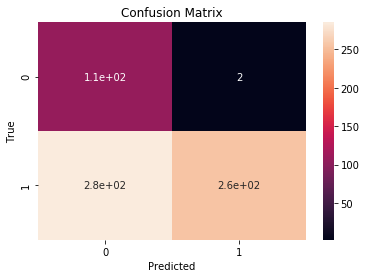

In [18]:
# Option 14

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_own = []
val_losses_own = []

test_accs_own = []
test_losses_own = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

for train_index, val_index in skf.split(df, df['label']):
  
  # for time efficiency, we train only once now
  if num_model == 2:
    break
  
  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()

  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=20
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)
  
  model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_own.append(score[1])
  test_losses_own.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


In [19]:
# summary of K-Fold validation

#avg_val_acc_own = np.mean(val_accs_own)
#avg_val_loss_own = np.mean(val_losses_own)

#print("validation accuracy is " + str(avg_val_acc_own))
#print("validation loss is " + str(avg_val_loss_own))

#avg_test_acc_own = np.mean(test_accs_own)
#avg_test_loss_own = np.mean(test_losses_own)

#print("test accuracy is " + str(avg_test_acc_own))
#print("test loss is " + str(avg_test_loss_own))


# 2.2. VGG 16

Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 7 steps
Epoch 1/5
25/25 [==============================] - 29s 1s/step - loss: 0.6155 - accuracy: 0.7672 - val_loss: 0.4073 - val_accuracy: 0.7700
Epoch 2/5
25/25 [==============================] - 28s 1s/step - loss: 0.3605 - accuracy: 0.8385 - val_loss: 0.3505 - val_accuracy: 0.8650
Epoch 3/5
25/25 [==============================] - 28s 1s/step - loss: 0.3327 - accuracy: 0.8548 - val_loss: 0.3233 - val_accuracy: 0.8800
Epoch 4/5
25/25 [==============================] - 28s 1s/step - loss: 0.3122 - accuracy: 0.8786 - val_loss: 0.3119 - val_accuracy: 0.8950
Epoch 5/5
25/25 [==============================] - 28s 1s/step - loss: 0.3050 - accuracy: 0.8698 - val_loss: 0.3043 - val_accuracy: 0.8650
  ...
    to  
  ['...']
21/21 [==============================] - 7s 326ms/step - loss: 2.8577

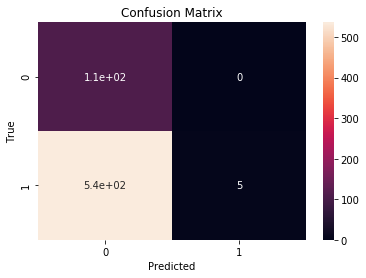

In [20]:
# Option 1

from tensorflow.keras.applications import VGG16

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_vgg = []
val_losses_vgg = []

test_accs_vgg = []
test_losses_vgg = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_vgg = VGG16(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_vgg.layers[:(len(pre_model_vgg.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break
  
  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_vgg,
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/vgg16_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()

  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)
  
  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/vgg16_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_vgg.append(history.history['val_accuracy'])
  val_losses_vgg.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_vgg.append(score[1])
  test_losses_vgg.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 7 steps
Epoch 1/10
25/25 [==============================] - 29s 1s/step - loss: 0.6687 - accuracy: 0.7334 - val_loss: 0.4174 - val_accuracy: 0.8050
Epoch 2/10
25/25 [==============================] - 28s 1s/step - loss: 0.3382 - accuracy: 0.8586 - val_loss: 0.3058 - val_accuracy: 0.9000
Epoch 3/10
25/25 [==============================] - 28s 1s/step - loss: 0.2534 - accuracy: 0.8974 - val_loss: 0.1869 - val_accuracy: 0.9200
Epoch 4/10
25/25 [==============================] - 28s 1s/step - loss: 0.1740 - accuracy: 0.9299 - val_loss: 0.9826 - val_accuracy: 0.7550
Epoch 5/10
25/25 [==============================] - 28s 1s/step - loss: 0.2113 - accuracy: 0.9224 - val_loss: 0.2358 - val_accuracy: 0.9250
Epoch 6/10
25/25 [==============================] - 28s 1s/step - loss: 0.1646 - accuracy

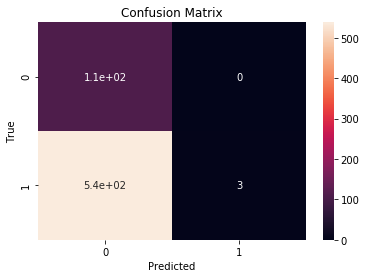

In [21]:
# Option 2

from tensorflow.keras.applications import VGG16

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_vgg = []
val_losses_vgg = []

test_accs_vgg = []
test_losses_vgg = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_vgg = VGG16(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_vgg.layers[:(len(pre_model_vgg.layers)-5)]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break
  
  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_vgg,
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/vgg16_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()

  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)
  
  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/vgg16_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_vgg.append(history.history['val_accuracy'])
  val_losses_vgg.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_vgg.append(score[1])
  test_losses_vgg.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 7 steps
Epoch 1/10
25/25 [==============================] - 29s 1s/step - loss: 0.5595 - accuracy: 0.7497 - val_loss: 0.3088 - val_accuracy: 0.8400
Epoch 2/10
25/25 [==============================] - 28s 1s/step - loss: 0.3142 - accuracy: 0.8598 - val_loss: 0.2532 - val_accuracy: 0.9000
Epoch 3/10
25/25 [==============================] - 28s 1s/step - loss: 0.2359 - accuracy: 0.9061 - val_loss: 0.2806 - val_accuracy: 0.8850
Epoch 4/10
25/25 [==============================] - 28s 1s/step - loss: 0.1922 - accuracy: 0.9149 - val_loss: 0.1648 - val_accuracy: 0.9550
Epoch 5/10
25/25 [==============================] - 29s 1s/step - loss: 0.1392 - accuracy: 0.9512 - val_loss: 0.1504 - val_accuracy: 0.9400
Epoch 6/10
25/25 [==============================] - 28s 1s/step - loss: 0.1401 - accuracy

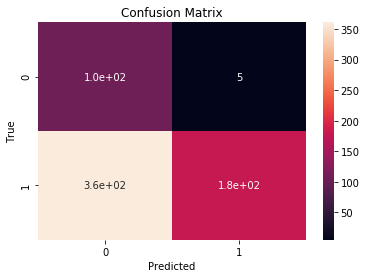

In [22]:
# Option 3

from tensorflow.keras.applications import VGG16

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_vgg = []
val_losses_vgg = []

test_accs_vgg = []
test_losses_vgg = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_vgg = VGG16(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_vgg.layers[:(len(pre_model_vgg.layers)-3)]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break
  
  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_vgg,
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/vgg16_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()

  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)
  
  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/vgg16_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_vgg.append(history.history['val_accuracy'])
  val_losses_vgg.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_vgg.append(score[1])
  test_losses_vgg.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 7 steps
Epoch 1/10
25/25 [==============================] - 28s 1s/step - loss: 0.6858 - accuracy: 0.7209 - val_loss: 0.3985 - val_accuracy: 0.7550
Epoch 2/10
25/25 [==============================] - 28s 1s/step - loss: 0.3785 - accuracy: 0.7559 - val_loss: 0.3318 - val_accuracy: 0.7550
Epoch 3/10
25/25 [==============================] - 28s 1s/step - loss: 0.3445 - accuracy: 0.8548 - val_loss: 0.3200 - val_accuracy: 0.8600
Epoch 4/10
25/25 [==============================] - 28s 1s/step - loss: 0.3211 - accuracy: 0.8773 - val_loss: 0.3105 - val_accuracy: 0.8600
Epoch 5/10
25/25 [==============================] - 28s 1s/step - loss: 0.3237 - accuracy: 0.8786 - val_loss: 0.2964 - val_accuracy: 0.8900
Epoch 6/10
25/25 [==============================] - 28s 1s/step - loss: 0.2985 - accuracy

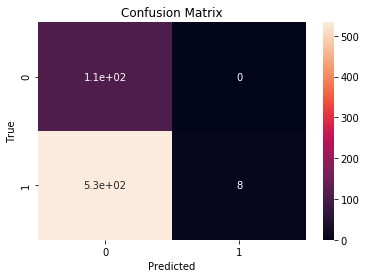

In [23]:
# Option 4

from tensorflow.keras.applications import VGG16

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_vgg = []
val_losses_vgg = []

test_accs_vgg = []
test_losses_vgg = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_vgg = VGG16(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_vgg.layers[:(len(pre_model_vgg.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break
  
  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_vgg,
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/vgg16_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()

  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)
  
  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/vgg16_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_vgg.append(history.history['val_accuracy'])
  val_losses_vgg.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_vgg.append(score[1])
  test_losses_vgg.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/5
8/8 [==============================] - 29s 4s/step - loss: 0.9352 - accuracy: 0.7797 - val_loss: 0.5074 - val_accuracy: 0.7550
Epoch 2/5
8/8 [==============================] - 29s 4s/step - loss: 0.4403 - accuracy: 0.7559 - val_loss: 0.3874 - val_accuracy: 0.7550
Epoch 3/5
8/8 [==============================] - 29s 4s/step - loss: 0.3821 - accuracy: 0.8110 - val_loss: 0.3550 - val_accuracy: 0.8050
Epoch 4/5
8/8 [==============================] - 28s 4s/step - loss: 0.3560 - accuracy: 0.8235 - val_loss: 0.3451 - val_accuracy: 0.8400
Epoch 5/5
8/8 [==============================] - 29s 4s/step - loss: 0.3433 - accuracy: 0.8636 - val_loss: 0.3311 - val_accuracy: 0.8550
  ...
    to  
  ['...']
21/21 [==============================] - 6s 304ms/step - loss: 2.0220 - accuracy

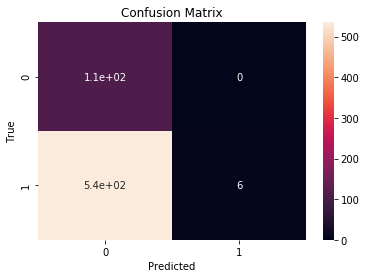

In [24]:
# Option 5

from tensorflow.keras.applications import VGG16

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_vgg = []
val_losses_vgg = []

test_accs_vgg = []
test_losses_vgg = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_vgg = VGG16(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_vgg.layers[:(len(pre_model_vgg.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break
  
  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_vgg,
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/vgg16_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()

  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)
  
  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/vgg16_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_vgg.append(history.history['val_accuracy'])
  val_losses_vgg.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_vgg.append(score[1])
  test_losses_vgg.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/20
8/8 [==============================] - 29s 4s/step - loss: 0.7986 - accuracy: 0.7434 - val_loss: 0.4013 - val_accuracy: 0.7550
Epoch 2/20
8/8 [==============================] - 30s 4s/step - loss: 0.4466 - accuracy: 0.7559 - val_loss: 0.3669 - val_accuracy: 0.8350
Epoch 3/20
8/8 [==============================] - 29s 4s/step - loss: 0.4057 - accuracy: 0.8586 - val_loss: 0.3376 - val_accuracy: 0.8250
Epoch 4/20
8/8 [==============================] - 29s 4s/step - loss: 0.3609 - accuracy: 0.8310 - val_loss: 0.3236 - val_accuracy: 0.8900
Epoch 5/20
8/8 [==============================] - 29s 4s/step - loss: 0.3493 - accuracy: 0.8673 - val_loss: 0.3282 - val_accuracy: 0.8850
Epoch 6/20
8/8 [==============================] - 29s 4s/step - loss: 0.3200 - accuracy: 0.8798 - va

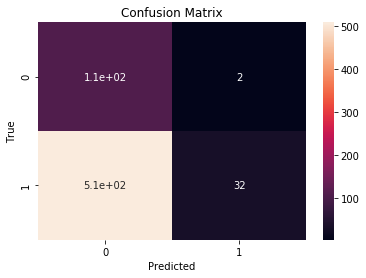

In [25]:
# Option 6

from tensorflow.keras.applications import VGG16

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_vgg = []
val_losses_vgg = []

test_accs_vgg = []
test_losses_vgg = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_vgg = VGG16(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_vgg.layers[:(len(pre_model_vgg.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break
  
  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_vgg,
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/vgg16_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()

  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=20
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)
  
  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/vgg16_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_vgg.append(history.history['val_accuracy'])
  val_losses_vgg.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_vgg.append(score[1])
  test_losses_vgg.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 7 steps
Epoch 1/10
25/25 [==============================] - 29s 1s/step - loss: 1.0042 - accuracy: 0.6333 - val_loss: 0.6572 - val_accuracy: 0.7550
Epoch 2/10
25/25 [==============================] - 28s 1s/step - loss: 0.5717 - accuracy: 0.7559 - val_loss: 0.5307 - val_accuracy: 0.7550
Epoch 3/10
25/25 [==============================] - 28s 1s/step - loss: 0.5040 - accuracy: 0.7559 - val_loss: 0.4838 - val_accuracy: 0.7550
Epoch 4/10
25/25 [==============================] - 28s 1s/step - loss: 0.4361 - accuracy: 0.7559 - val_loss: 0.4098 - val_accuracy: 0.7550
Epoch 5/10
25/25 [==============================] - 28s 1s/step - loss: 0.3784 - accuracy: 0.7559 - val_loss: 0.3694 - val_accuracy: 0.7550
Epoch 6/10
25/25 [==============================] - 28s 1s/step - loss: 0.3545 - accuracy

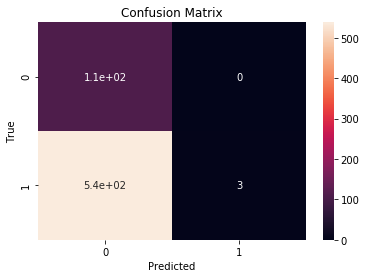

In [26]:
# Option 7

from tensorflow.keras.applications import VGG16

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_vgg = []
val_losses_vgg = []

test_accs_vgg = []
test_losses_vgg = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_vgg = VGG16(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_vgg.layers[:(len(pre_model_vgg.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break
  
  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_vgg,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/vgg16_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()

  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)
  
  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/vgg16_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_vgg.append(history.history['val_accuracy'])
  val_losses_vgg.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_vgg.append(score[1])
  test_losses_vgg.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/5
8/8 [==============================] - 29s 4s/step - loss: 1.1819 - accuracy: 0.6345 - val_loss: 0.4799 - val_accuracy: 0.7550
Epoch 2/5
8/8 [==============================] - 29s 4s/step - loss: 0.4524 - accuracy: 0.7785 - val_loss: 0.3508 - val_accuracy: 0.8700
Epoch 3/5
8/8 [==============================] - 29s 4s/step - loss: 0.3213 - accuracy: 0.8686 - val_loss: 0.3585 - val_accuracy: 0.8450
Epoch 4/5
8/8 [==============================] - 28s 4s/step - loss: 0.2940 - accuracy: 0.8698 - val_loss: 0.2692 - val_accuracy: 0.8850
Epoch 5/5
8/8 [==============================] - 29s 4s/step - loss: 0.2778 - accuracy: 0.8798 - val_loss: 0.2712 - val_accuracy: 0.9050
  ...
    to  
  ['...']
21/21 [==============================] - 6s 301ms/step - loss: 2.0495 - accuracy

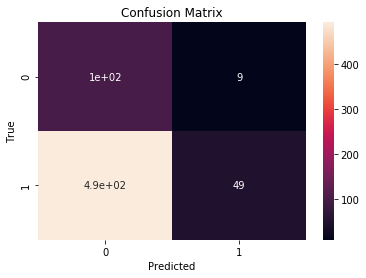

In [27]:
# Option 8

from tensorflow.keras.applications import VGG16

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_vgg = []
val_losses_vgg = []

test_accs_vgg = []
test_losses_vgg = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_vgg = VGG16(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_vgg.layers[:(len(pre_model_vgg.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break
  
  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_vgg,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/vgg16_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()

  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)
  
  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/vgg16_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_vgg.append(history.history['val_accuracy'])
  val_losses_vgg.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_vgg.append(score[1])
  test_losses_vgg.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/20
8/8 [==============================] - 29s 4s/step - loss: 1.1021 - accuracy: 0.6133 - val_loss: 0.4320 - val_accuracy: 0.7550
Epoch 2/20
8/8 [==============================] - 29s 4s/step - loss: 0.4941 - accuracy: 0.7622 - val_loss: 0.3662 - val_accuracy: 0.8100
Epoch 3/20
8/8 [==============================] - 28s 4s/step - loss: 0.3802 - accuracy: 0.8573 - val_loss: 0.3621 - val_accuracy: 0.7850
Epoch 4/20
8/8 [==============================] - 29s 4s/step - loss: 0.3568 - accuracy: 0.8248 - val_loss: 0.2946 - val_accuracy: 0.8950
Epoch 5/20
8/8 [==============================] - 29s 4s/step - loss: 0.2949 - accuracy: 0.8824 - val_loss: 0.2735 - val_accuracy: 0.8950
Epoch 6/20
8/8 [==============================] - 28s 4s/step - loss: 0.2747 - accuracy: 0.8824 - va

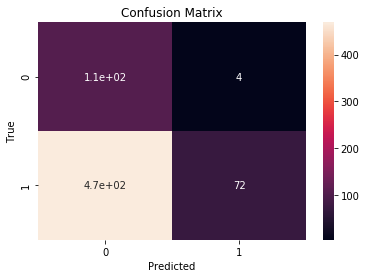

In [28]:
# Option 9

from tensorflow.keras.applications import VGG16

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_vgg = []
val_losses_vgg = []

test_accs_vgg = []
test_losses_vgg = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_vgg = VGG16(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_vgg.layers[:(len(pre_model_vgg.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break
  
  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_vgg,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/vgg16_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()

  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=20
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)
  
  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/vgg16_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_vgg.append(history.history['val_accuracy'])
  val_losses_vgg.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_vgg.append(score[1])
  test_losses_vgg.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 7 steps
Epoch 1/5
25/25 [==============================] - 29s 1s/step - loss: 0.7112 - accuracy: 0.7334 - val_loss: 0.6667 - val_accuracy: 0.7550
Epoch 2/5
25/25 [==============================] - 28s 1s/step - loss: 0.6372 - accuracy: 0.7559 - val_loss: 0.6208 - val_accuracy: 0.7550
Epoch 3/5
25/25 [==============================] - 29s 1s/step - loss: 0.5762 - accuracy: 0.7559 - val_loss: 0.5651 - val_accuracy: 0.7550
Epoch 4/5
25/25 [==============================] - 28s 1s/step - loss: 0.5468 - accuracy: 0.7559 - val_loss: 0.5242 - val_accuracy: 0.7550
Epoch 5/5
25/25 [==============================] - 28s 1s/step - loss: 0.5175 - accuracy: 0.7559 - val_loss: 0.5102 - val_accuracy: 0.7550
  ...
    to  
  ['...']
21/21 [==============================] - 6s 302ms/step - loss: 1.3803

C:\Users\server\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


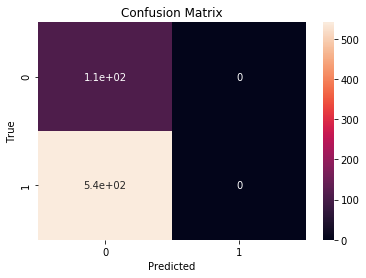

In [29]:
# Option 10

from tensorflow.keras.applications import VGG16

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_vgg = []
val_losses_vgg = []

test_accs_vgg = []
test_losses_vgg = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_vgg = VGG16(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_vgg.layers[:(len(pre_model_vgg.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break
  
  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_vgg,
    layers.Flatten(),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/vgg16_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()

  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)
  
  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/vgg16_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_vgg.append(history.history['val_accuracy'])
  val_losses_vgg.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_vgg.append(score[1])
  test_losses_vgg.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 7 steps
Epoch 1/10
25/25 [==============================] - 29s 1s/step - loss: 0.3219 - accuracy: 0.8586 - val_loss: 0.3616 - val_accuracy: 0.8500
Epoch 2/10
25/25 [==============================] - 28s 1s/step - loss: 0.2284 - accuracy: 0.9086 - val_loss: 0.3190 - val_accuracy: 0.8750
Epoch 3/10
25/25 [==============================] - 28s 1s/step - loss: 0.2273 - accuracy: 0.9111 - val_loss: 0.2982 - val_accuracy: 0.8950
Epoch 4/10
25/25 [==============================] - 28s 1s/step - loss: 0.2058 - accuracy: 0.9199 - val_loss: 0.3163 - val_accuracy: 0.8700
Epoch 5/10
25/25 [==============================] - 28s 1s/step - loss: 0.1584 - accuracy: 0.9437 - val_loss: 0.2956 - val_accuracy: 0.9000
Epoch 6/10
25/25 [==============================] - 28s 1s/step - loss: 0.1744 - accuracy

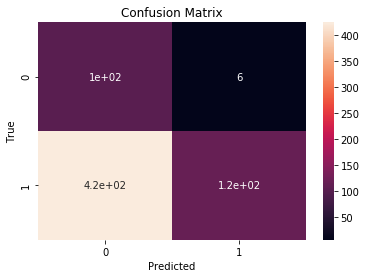

In [30]:
# Option 11

from tensorflow.keras.applications import VGG16

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_vgg = []
val_losses_vgg = []

test_accs_vgg = []
test_losses_vgg = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_vgg = VGG16(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_vgg.layers[:(len(pre_model_vgg.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break
  
  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_vgg,
    layers.Flatten(),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/vgg16_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()

  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)
  
  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/vgg16_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_vgg.append(history.history['val_accuracy'])
  val_losses_vgg.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_vgg.append(score[1])
  test_losses_vgg.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/5
8/8 [==============================] - 29s 4s/step - loss: 0.8248 - accuracy: 0.6884 - val_loss: 0.7861 - val_accuracy: 0.7550
Epoch 2/5
8/8 [==============================] - 29s 4s/step - loss: 0.7367 - accuracy: 0.7559 - val_loss: 0.7242 - val_accuracy: 0.7550
Epoch 3/5
8/8 [==============================] - 28s 4s/step - loss: 0.7129 - accuracy: 0.7559 - val_loss: 0.7044 - val_accuracy: 0.7550
Epoch 4/5
8/8 [==============================] - 29s 4s/step - loss: 0.6928 - accuracy: 0.7559 - val_loss: 0.6860 - val_accuracy: 0.7550
Epoch 5/5
8/8 [==============================] - 28s 4s/step - loss: 0.6759 - accuracy: 0.7559 - val_loss: 0.6678 - val_accuracy: 0.7550
  ...
    to  
  ['...']
21/21 [==============================] - 7s 310ms/step - loss: 2.0478 - accuracy

C:\Users\server\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


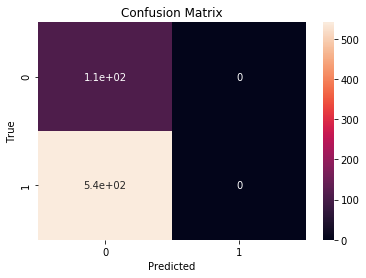

In [31]:
# Option 12

from tensorflow.keras.applications import VGG16

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_vgg = []
val_losses_vgg = []

test_accs_vgg = []
test_losses_vgg = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_vgg = VGG16(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_vgg.layers[:(len(pre_model_vgg.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break
  
  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_vgg,
    layers.Flatten(),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/vgg16_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()

  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)
  
  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/vgg16_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_vgg.append(history.history['val_accuracy'])
  val_losses_vgg.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_vgg.append(score[1])
  test_losses_vgg.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/20
8/8 [==============================] - 29s 4s/step - loss: 0.7787 - accuracy: 0.7121 - val_loss: 0.7700 - val_accuracy: 0.7550
Epoch 2/20
8/8 [==============================] - 29s 4s/step - loss: 0.6912 - accuracy: 0.7559 - val_loss: 0.6569 - val_accuracy: 0.7550
Epoch 3/20
8/8 [==============================] - 29s 4s/step - loss: 0.6340 - accuracy: 0.7559 - val_loss: 0.6190 - val_accuracy: 0.7550
Epoch 4/20
8/8 [==============================] - 28s 4s/step - loss: 0.6102 - accuracy: 0.7559 - val_loss: 0.6030 - val_accuracy: 0.7550
Epoch 5/20
8/8 [==============================] - 28s 4s/step - loss: 0.5946 - accuracy: 0.7559 - val_loss: 0.5900 - val_accuracy: 0.7550
Epoch 6/20
8/8 [==============================] - 28s 4s/step - loss: 0.5841 - accuracy: 0.7559 - va

C:\Users\server\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


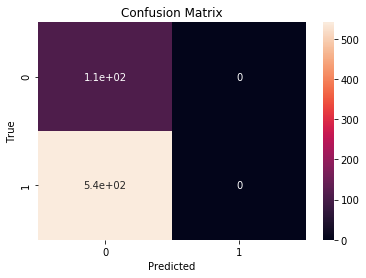

In [32]:
# Option 13

from tensorflow.keras.applications import VGG16

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_vgg = []
val_losses_vgg = []

test_accs_vgg = []
test_losses_vgg = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_vgg = VGG16(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_vgg.layers[:(len(pre_model_vgg.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break
  
  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_vgg,
    layers.Flatten(),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/vgg16_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()

  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=20
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)
  
  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/vgg16_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_vgg.append(history.history['val_accuracy'])
  val_losses_vgg.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_vgg.append(score[1])
  test_losses_vgg.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 7 steps
Epoch 1/10
25/25 [==============================] - 29s 1s/step - loss: 0.8278 - accuracy: 0.7334 - val_loss: 0.6445 - val_accuracy: 0.7550
Epoch 2/10
25/25 [==============================] - 28s 1s/step - loss: 0.5620 - accuracy: 0.7559 - val_loss: 0.5350 - val_accuracy: 0.7550
Epoch 3/10
25/25 [==============================] - 28s 1s/step - loss: 0.4731 - accuracy: 0.7559 - val_loss: 0.4444 - val_accuracy: 0.7550
Epoch 4/10
25/25 [==============================] - 28s 1s/step - loss: 0.4298 - accuracy: 0.7559 - val_loss: 0.4315 - val_accuracy: 0.7550
Epoch 5/10
25/25 [==============================] - 28s 1s/step - loss: 0.4092 - accuracy: 0.7559 - val_loss: 0.3953 - val_accuracy: 0.7550
Epoch 6/10
25/25 [==============================] - 28s 1s/step - loss: 0.3838 - accuracy

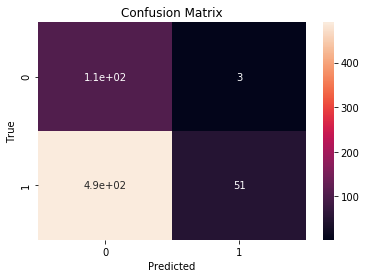

In [33]:
# Option 14

from tensorflow.keras.applications import VGG16

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_vgg = []
val_losses_vgg = []

test_accs_vgg = []
test_losses_vgg = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_vgg = VGG16(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_vgg.layers[:(len(pre_model_vgg.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break
  
  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_vgg,
    layers.Flatten(),
    layers.Dense(64, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/vgg16_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()

  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)
  
  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/vgg16_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_vgg.append(history.history['val_accuracy'])
  val_losses_vgg.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_vgg.append(score[1])
  test_losses_vgg.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/5
8/8 [==============================] - 29s 4s/step - loss: 0.6066 - accuracy: 0.7810 - val_loss: 0.4320 - val_accuracy: 0.8600
Epoch 2/5
8/8 [==============================] - 29s 4s/step - loss: 0.3965 - accuracy: 0.8473 - val_loss: 0.3517 - val_accuracy: 0.8500
Epoch 3/5
8/8 [==============================] - 29s 4s/step - loss: 0.3483 - accuracy: 0.8536 - val_loss: 0.3062 - val_accuracy: 0.8700
Epoch 4/5
8/8 [==============================] - 29s 4s/step - loss: 0.3130 - accuracy: 0.8773 - val_loss: 0.2937 - val_accuracy: 0.8750
Epoch 5/5
8/8 [==============================] - 28s 4s/step - loss: 0.2889 - accuracy: 0.8849 - val_loss: 0.2633 - val_accuracy: 0.9250
  ...
    to  
  ['...']
21/21 [==============================] - 6s 302ms/step - loss: 1.7324 - accuracy

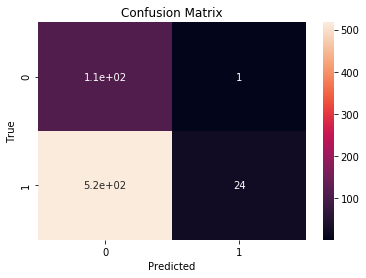

In [34]:
# Option 15

from tensorflow.keras.applications import VGG16

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_vgg = []
val_losses_vgg = []

test_accs_vgg = []
test_losses_vgg = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_vgg = VGG16(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_vgg.layers[:(len(pre_model_vgg.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break
  
  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_vgg,
    layers.Flatten(),
    layers.Dense(64, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/vgg16_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()

  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)
  
  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/vgg16_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_vgg.append(history.history['val_accuracy'])
  val_losses_vgg.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_vgg.append(score[1])
  test_losses_vgg.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/20
8/8 [==============================] - 29s 4s/step - loss: 0.6917 - accuracy: 0.6846 - val_loss: 0.4248 - val_accuracy: 0.7550
Epoch 2/20
8/8 [==============================] - 28s 4s/step - loss: 0.4052 - accuracy: 0.8411 - val_loss: 0.3385 - val_accuracy: 0.8750
Epoch 3/20
8/8 [==============================] - 28s 4s/step - loss: 0.3353 - accuracy: 0.8511 - val_loss: 0.3170 - val_accuracy: 0.8850
Epoch 4/20
8/8 [==============================] - 28s 4s/step - loss: 0.3159 - accuracy: 0.8786 - val_loss: 0.2782 - val_accuracy: 0.8900
Epoch 5/20
8/8 [==============================] - 29s 4s/step - loss: 0.3009 - accuracy: 0.8899 - val_loss: 0.2671 - val_accuracy: 0.9100
Epoch 6/20
8/8 [==============================] - 29s 4s/step - loss: 0.2857 - accuracy: 0.8874 - va

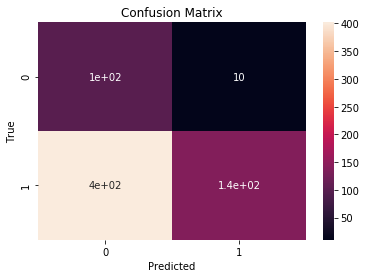

In [35]:
# Option 16

from tensorflow.keras.applications import VGG16

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_vgg = []
val_losses_vgg = []

test_accs_vgg = []
test_losses_vgg = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_vgg = VGG16(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_vgg.layers[:(len(pre_model_vgg.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break
  
  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_vgg,
    layers.Flatten(),
    layers.Dense(64, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/vgg16_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()

  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=20
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)
  
  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/vgg16_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_vgg.append(history.history['val_accuracy'])
  val_losses_vgg.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_vgg.append(score[1])
  test_losses_vgg.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


In [36]:
#avg_val_acc_vgg = np.mean(val_accs_vgg)
#avg_val_loss_vgg = np.mean(val_losses_vgg)

#print("validation accuracy is " + str(avg_val_acc_vgg))
#print("validation loss is " + str(avg_val_loss_vgg))

#avg_test_acc_vgg = np.mean(test_accs_vgg)
#avg_test_loss_vgg = np.mean(test_losses_vgg)

#print("test accuracy is " + str(avg_test_acc_vgg))
#print("test loss is " + str(avg_test_loss_vgg))


# 2.3. ResNet

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 4d473c1dd8becc155b73f8504c6f6626 so we will re-download the data.
94773248/94765736 [==============================] - 10s 0us/step
Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 7 steps
Epoch 1/5
25/25 [==============================] - 31s 1s/step - loss: 3.0717 - accuracy: 0.6821 - val_loss: 0.6907 - val_accuracy: 0.7550
Epoch 2/5
25/25 [==============================] - 28s 1s/step - loss: 0.4180 - accuracy: 0.7559 - val_loss: 0.7176 - val_accuracy: 0.7550
Epoch 3/5
25/25 [==============================] - 28s 1s/step - loss: 0.2600 - accuracy: 0.7559 - val_loss: 0.5468 - val_accuracy: 0.7550
Epoch 4/5
25/25 [==============================] - 28s 1s/step - loss: 0.2532 - accuracy: 0.7885 - val_loss: 0

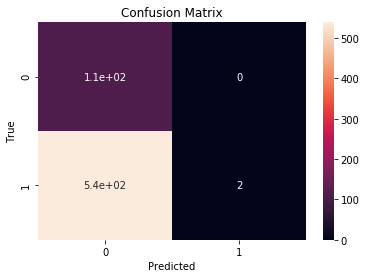

In [37]:
# Option 1

from tensorflow.keras.applications import ResNet50

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_res = ResNet50(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_res.layers[:(len(pre_model_res.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  time_callback = TimeHistory()

  # model structure
  model = Sequential([
    pre_model_res,
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/resnet_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/resnet_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_res.append(history.history['val_accuracy'])
  val_losses_res.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 7 steps
Epoch 1/10
25/25 [==============================] - 30s 1s/step - loss: 2.3336 - accuracy: 0.6971 - val_loss: 0.6597 - val_accuracy: 0.7550
Epoch 2/10
25/25 [==============================] - 28s 1s/step - loss: 0.2652 - accuracy: 0.9212 - val_loss: 0.6569 - val_accuracy: 0.7550
Epoch 3/10
25/25 [==============================] - 28s 1s/step - loss: 0.2306 - accuracy: 0.9549 - val_loss: 0.6736 - val_accuracy: 0.7500
Epoch 4/10
25/25 [==============================] - 28s 1s/step - loss: 0.1978 - accuracy: 0.9687 - val_loss: 0.6893 - val_accuracy: 0.5050
Epoch 5/10
25/25 [==============================] - 30s 1s/step - loss: 0.2005 - accuracy: 0.9762 - val_loss: 0.6240 - val_accuracy: 0.7550
Epoch 6/10
25/25 [==============================] - 28s 1s/step - loss: 0.1909 - accuracy

C:\Users\server\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


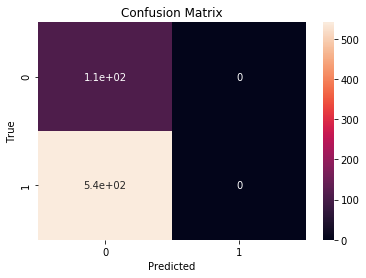

In [38]:
# Option 2

from tensorflow.keras.applications import ResNet50

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_res = ResNet50(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_res.layers[:(len(pre_model_res.layers)-15)]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  time_callback = TimeHistory()

  # model structure
  model = Sequential([
    pre_model_res,
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/resnet_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/resnet_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_res.append(history.history['val_accuracy'])
  val_losses_res.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 7 steps
Epoch 1/10
25/25 [==============================] - 31s 1s/step - loss: 1.3199 - accuracy: 0.9036 - val_loss: 0.5672 - val_accuracy: 0.7500
Epoch 2/10
25/25 [==============================] - 28s 1s/step - loss: 0.1849 - accuracy: 0.9725 - val_loss: 4.7008 - val_accuracy: 0.2450
Epoch 3/10
25/25 [==============================] - 28s 1s/step - loss: 0.1414 - accuracy: 0.9862 - val_loss: 8.0063 - val_accuracy: 0.2450
Epoch 4/10
25/25 [==============================] - 28s 1s/step - loss: 0.0683 - accuracy: 0.9850 - val_loss: 5.0818 - val_accuracy: 0.2450
Epoch 5/10
25/25 [==============================] - 28s 1s/step - loss: 0.0646 - accuracy: 0.9850 - val_loss: 4.2860 - val_accuracy: 0.2450
Epoch 6/10
25/25 [==============================] - 28s 1s/step - loss: 0.0438 - accuracy

C:\Users\server\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


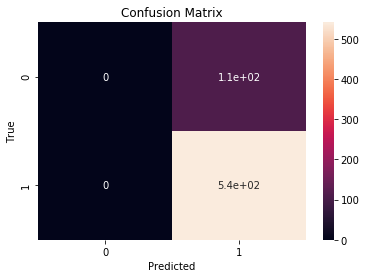

In [39]:
# Option 3

from tensorflow.keras.applications import ResNet50

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_res = ResNet50(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_res.layers[:(len(pre_model_res.layers)-10)]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  time_callback = TimeHistory()

  # model structure
  model = Sequential([
    pre_model_res,
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/resnet_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/resnet_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_res.append(history.history['val_accuracy'])
  val_losses_res.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 7 steps
Epoch 1/10
25/25 [==============================] - 31s 1s/step - loss: 1.1912 - accuracy: 0.8686 - val_loss: 5.0927 - val_accuracy: 0.2450
Epoch 2/10
25/25 [==============================] - 29s 1s/step - loss: 0.1470 - accuracy: 0.9650 - val_loss: 4.5567 - val_accuracy: 0.2450
Epoch 3/10
25/25 [==============================] - 29s 1s/step - loss: 0.1114 - accuracy: 0.9762 - val_loss: 2.7067 - val_accuracy: 0.2450
Epoch 4/10
25/25 [==============================] - 29s 1s/step - loss: 0.1666 - accuracy: 0.9562 - val_loss: 3.5541 - val_accuracy: 0.2450
Epoch 5/10
25/25 [==============================] - 29s 1s/step - loss: 0.0661 - accuracy: 0.9800 - val_loss: 1.8922 - val_accuracy: 0.2450
Epoch 6/10
25/25 [==============================] - 29s 1s/step - loss: 0.0923 - accuracy

C:\Users\server\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


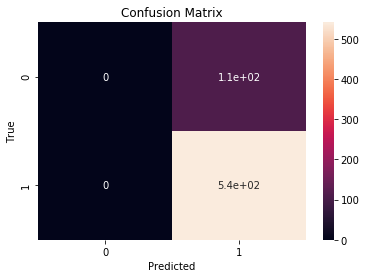

In [40]:
# Option 4

from tensorflow.keras.applications import ResNet50

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_res = ResNet50(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_res.layers[:(len(pre_model_res.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  time_callback = TimeHistory()

  # model structure
  model = Sequential([
    pre_model_res,
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/resnet_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/resnet_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_res.append(history.history['val_accuracy'])
  val_losses_res.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/5
8/8 [==============================] - 32s 4s/step - loss: 5.7657 - accuracy: 0.6671 - val_loss: 0.6932 - val_accuracy: 0.2450
Epoch 2/5
8/8 [==============================] - 29s 4s/step - loss: 0.6784 - accuracy: 0.6345 - val_loss: 0.6922 - val_accuracy: 0.7550
Epoch 3/5
8/8 [==============================] - 30s 4s/step - loss: 0.6258 - accuracy: 0.7559 - val_loss: 0.6391 - val_accuracy: 0.7550
Epoch 4/5
8/8 [==============================] - 29s 4s/step - loss: 0.3644 - accuracy: 0.7559 - val_loss: 1.0344 - val_accuracy: 0.7550
Epoch 5/5
8/8 [==============================] - 29s 4s/step - loss: 0.3199 - accuracy: 0.7559 - val_loss: 0.7924 - val_accuracy: 0.7550
  ...
    to  
  ['...']
21/21 [==============================] - 6s 306ms/step - loss: 2.6578 - accuracy

C:\Users\server\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


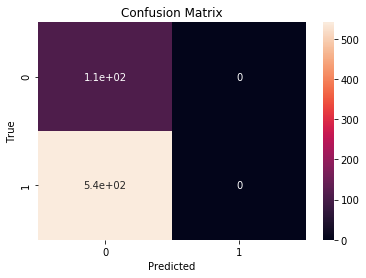

In [41]:
# Option 5

from tensorflow.keras.applications import ResNet50

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_res = ResNet50(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_res.layers[:(len(pre_model_res.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  time_callback = TimeHistory()

  # model structure
  model = Sequential([
    pre_model_res,
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/resnet_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/resnet_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_res.append(history.history['val_accuracy'])
  val_losses_res.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/20
8/8 [==============================] - 31s 4s/step - loss: 6.7328 - accuracy: 0.7046 - val_loss: 0.6933 - val_accuracy: 0.2450
Epoch 2/20
8/8 [==============================] - 29s 4s/step - loss: 0.6754 - accuracy: 0.5219 - val_loss: 0.6926 - val_accuracy: 0.7550
Epoch 3/20
8/8 [==============================] - 29s 4s/step - loss: 0.6571 - accuracy: 0.7559 - val_loss: 0.6910 - val_accuracy: 0.7550
Epoch 4/20
8/8 [==============================] - 29s 4s/step - loss: 0.5174 - accuracy: 0.7559 - val_loss: 0.5577 - val_accuracy: 0.7550
Epoch 5/20
8/8 [==============================] - 29s 4s/step - loss: 0.3799 - accuracy: 0.7559 - val_loss: 1.0295 - val_accuracy: 0.7550
Epoch 6/20
8/8 [==============================] - 29s 4s/step - loss: 0.3296 - accuracy: 0.7559 - va

C:\Users\server\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


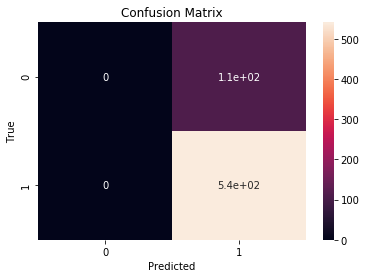

In [42]:
# Option 6

from tensorflow.keras.applications import ResNet50

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_res = ResNet50(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_res.layers[:(len(pre_model_res.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  time_callback = TimeHistory()

  # model structure
  model = Sequential([
    pre_model_res,
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/resnet_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=20
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/resnet_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_res.append(history.history['val_accuracy'])
  val_losses_res.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 7 steps
Epoch 1/10
25/25 [==============================] - 31s 1s/step - loss: 3.5333 - accuracy: 0.6746 - val_loss: 0.6909 - val_accuracy: 0.7550
Epoch 2/10
25/25 [==============================] - 29s 1s/step - loss: 0.6882 - accuracy: 0.7559 - val_loss: 0.6853 - val_accuracy: 0.7550
Epoch 3/10
25/25 [==============================] - 29s 1s/step - loss: 0.6826 - accuracy: 0.7559 - val_loss: 0.6796 - val_accuracy: 0.7550
Epoch 4/10
25/25 [==============================] - 29s 1s/step - loss: 0.6770 - accuracy: 0.7559 - val_loss: 0.6742 - val_accuracy: 0.7550
Epoch 5/10
25/25 [==============================] - 29s 1s/step - loss: 0.6716 - accuracy: 0.7559 - val_loss: 0.6689 - val_accuracy: 0.7550
Epoch 6/10
25/25 [==============================] - 30s 1s/step - loss: 0.6664 - accuracy

C:\Users\server\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


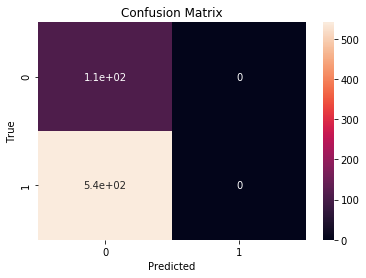

In [43]:
# Option 7

from tensorflow.keras.applications import ResNet50

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_res = ResNet50(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_res.layers[:(len(pre_model_res.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  time_callback = TimeHistory()

  # model structure
  model = Sequential([
    pre_model_res,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/resnet_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/resnet_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_res.append(history.history['val_accuracy'])
  val_losses_res.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/5
8/8 [==============================] - 31s 4s/step - loss: 4.2453 - accuracy: 0.7509 - val_loss: 1.7153 - val_accuracy: 0.7550
Epoch 2/5
8/8 [==============================] - 29s 4s/step - loss: 0.7877 - accuracy: 0.9049 - val_loss: 0.5588 - val_accuracy: 0.7550
Epoch 3/5
8/8 [==============================] - 28s 4s/step - loss: 0.2537 - accuracy: 0.9249 - val_loss: 0.8097 - val_accuracy: 0.2450
Epoch 4/5
8/8 [==============================] - 29s 4s/step - loss: 0.1137 - accuracy: 0.9524 - val_loss: 1.2028 - val_accuracy: 0.2450
Epoch 5/5
8/8 [==============================] - 29s 4s/step - loss: 0.0702 - accuracy: 0.9800 - val_loss: 0.9720 - val_accuracy: 0.2450
  ...
    to  
  ['...']
21/21 [==============================] - 6s 305ms/step - loss: 0.5129 - accuracy

C:\Users\server\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


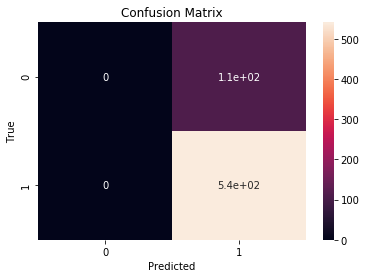

In [44]:
# Option 8

from tensorflow.keras.applications import ResNet50

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_res = ResNet50(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_res.layers[:(len(pre_model_res.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  time_callback = TimeHistory()

  # model structure
  model = Sequential([
    pre_model_res,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/resnet_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/resnet_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_res.append(history.history['val_accuracy'])
  val_losses_res.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/20
8/8 [==============================] - 31s 4s/step - loss: 8.4413 - accuracy: 0.4844 - val_loss: 0.6931 - val_accuracy: 0.7550
Epoch 2/20
8/8 [==============================] - 29s 4s/step - loss: 0.6925 - accuracy: 0.7559 - val_loss: 0.6917 - val_accuracy: 0.7550
Epoch 3/20
8/8 [==============================] - 29s 4s/step - loss: 0.6909 - accuracy: 0.7559 - val_loss: 0.6898 - val_accuracy: 0.7550
Epoch 4/20
8/8 [==============================] - 29s 4s/step - loss: 0.6890 - accuracy: 0.7559 - val_loss: 0.6880 - val_accuracy: 0.7550
Epoch 5/20
8/8 [==============================] - 29s 4s/step - loss: 0.6871 - accuracy: 0.7559 - val_loss: 0.6861 - val_accuracy: 0.7550
Epoch 6/20
8/8 [==============================] - 29s 4s/step - loss: 0.6852 - accuracy: 0.7559 - va

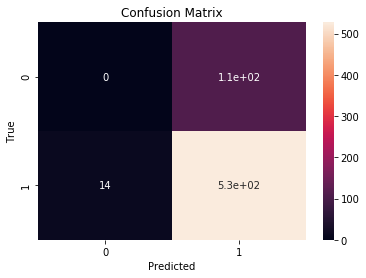

In [45]:
# Option 9

from tensorflow.keras.applications import ResNet50

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_res = ResNet50(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_res.layers[:(len(pre_model_res.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  time_callback = TimeHistory()

  # model structure
  model = Sequential([
    pre_model_res,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/resnet_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=20
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/resnet_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_res.append(history.history['val_accuracy'])
  val_losses_res.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 7 steps
Epoch 1/5
25/25 [==============================] - 31s 1s/step - loss: 0.7431 - accuracy: 0.7459 - val_loss: 0.7196 - val_accuracy: 0.7550
Epoch 2/5
25/25 [==============================] - 29s 1s/step - loss: 0.6663 - accuracy: 0.7559 - val_loss: 0.6393 - val_accuracy: 0.7550
Epoch 3/5
25/25 [==============================] - 29s 1s/step - loss: 0.6077 - accuracy: 0.7559 - val_loss: 0.5995 - val_accuracy: 0.7550
Epoch 4/5
25/25 [==============================] - 29s 1s/step - loss: 0.5702 - accuracy: 0.7559 - val_loss: 0.5709 - val_accuracy: 0.7550
Epoch 5/5
25/25 [==============================] - 28s 1s/step - loss: 0.5475 - accuracy: 0.7559 - val_loss: 0.5666 - val_accuracy: 0.7550
  ...
    to  
  ['...']
21/21 [==============================] - 6s 307ms/step - loss: 1.4139

C:\Users\server\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


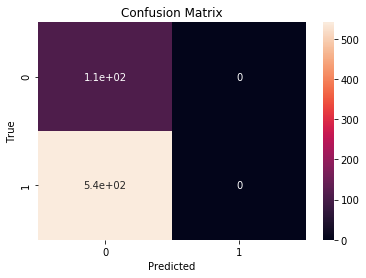

In [46]:
# Option 10

from tensorflow.keras.applications import ResNet50

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_res = ResNet50(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_res.layers[:(len(pre_model_res.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  time_callback = TimeHistory()

  # model structure
  model = Sequential([
    pre_model_res,
    layers.Flatten(),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/resnet_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/resnet_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_res.append(history.history['val_accuracy'])
  val_losses_res.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 7 steps
Epoch 1/10
25/25 [==============================] - 31s 1s/step - loss: 0.7780 - accuracy: 0.7372 - val_loss: 0.7529 - val_accuracy: 0.7550
Epoch 2/10
25/25 [==============================] - 29s 1s/step - loss: 0.7172 - accuracy: 0.7559 - val_loss: 0.6912 - val_accuracy: 0.7550
Epoch 3/10
25/25 [==============================] - 28s 1s/step - loss: 0.6631 - accuracy: 0.7559 - val_loss: 0.6405 - val_accuracy: 0.7550
Epoch 4/10
25/25 [==============================] - 29s 1s/step - loss: 0.6207 - accuracy: 0.7559 - val_loss: 0.6054 - val_accuracy: 0.7550
Epoch 5/10
25/25 [==============================] - 29s 1s/step - loss: 0.5919 - accuracy: 0.7559 - val_loss: 0.5815 - val_accuracy: 0.7550
Epoch 6/10
25/25 [==============================] - 29s 1s/step - loss: 0.5727 - accuracy

C:\Users\server\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


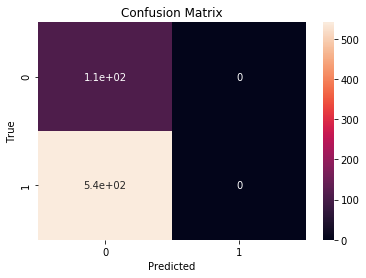

In [47]:
# Option 11

from tensorflow.keras.applications import ResNet50

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_res = ResNet50(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_res.layers[:(len(pre_model_res.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  time_callback = TimeHistory()

  # model structure
  model = Sequential([
    pre_model_res,
    layers.Flatten(),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/resnet_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/resnet_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_res.append(history.history['val_accuracy'])
  val_losses_res.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/5
8/8 [==============================] - 31s 4s/step - loss: 0.7294 - accuracy: 0.7059 - val_loss: 0.7042 - val_accuracy: 0.7550
Epoch 2/5
8/8 [==============================] - 29s 4s/step - loss: 0.6938 - accuracy: 0.7559 - val_loss: 0.6865 - val_accuracy: 0.7550
Epoch 3/5
8/8 [==============================] - 29s 4s/step - loss: 0.6762 - accuracy: 0.7559 - val_loss: 0.6684 - val_accuracy: 0.7550
Epoch 4/5
8/8 [==============================] - 29s 4s/step - loss: 0.6578 - accuracy: 0.7559 - val_loss: 0.6516 - val_accuracy: 0.7550
Epoch 5/5
8/8 [==============================] - 29s 4s/step - loss: 0.6418 - accuracy: 0.7559 - val_loss: 0.6358 - val_accuracy: 0.7550
  ...
    to  
  ['...']
21/21 [==============================] - 7s 321ms/step - loss: 1.8902 - accuracy

C:\Users\server\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


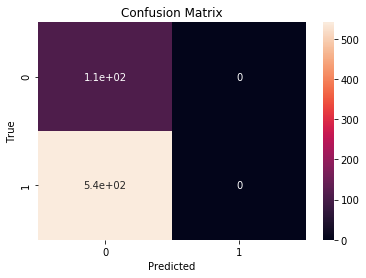

In [48]:
# Option 12

from tensorflow.keras.applications import ResNet50

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_res = ResNet50(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_res.layers[:(len(pre_model_res.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  time_callback = TimeHistory()

  # model structure
  model = Sequential([
    pre_model_res,
    layers.Flatten(),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/resnet_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/resnet_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_res.append(history.history['val_accuracy'])
  val_losses_res.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/20
8/8 [==============================] - 31s 4s/step - loss: 0.6006 - accuracy: 0.7559 - val_loss: 0.7612 - val_accuracy: 0.7550
Epoch 2/20
8/8 [==============================] - 29s 4s/step - loss: 0.3582 - accuracy: 0.8085 - val_loss: 0.7111 - val_accuracy: 0.7550
Epoch 3/20
8/8 [==============================] - 29s 4s/step - loss: 0.2858 - accuracy: 0.8924 - val_loss: 0.7569 - val_accuracy: 0.7550
Epoch 4/20
8/8 [==============================] - 29s 4s/step - loss: 0.2558 - accuracy: 0.9212 - val_loss: 0.7858 - val_accuracy: 0.7550
Epoch 5/20
8/8 [==============================] - 29s 4s/step - loss: 0.2238 - accuracy: 0.9212 - val_loss: 0.7622 - val_accuracy: 0.7550
Epoch 6/20
8/8 [==============================] - 29s 4s/step - loss: 0.2139 - accuracy: 0.9362 - va

C:\Users\server\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


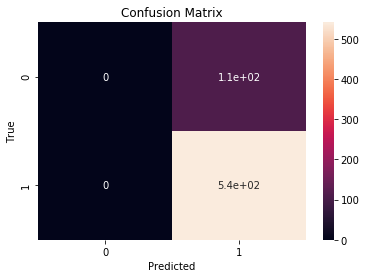

In [49]:
# Option 13

from tensorflow.keras.applications import ResNet50

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_res = ResNet50(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_res.layers[:(len(pre_model_res.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  time_callback = TimeHistory()

  # model structure
  model = Sequential([
    pre_model_res,
    layers.Flatten(),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/resnet_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=20
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/resnet_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_res.append(history.history['val_accuracy'])
  val_losses_res.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 7 steps
Epoch 1/10
25/25 [==============================] - 32s 1s/step - loss: 1.0915 - accuracy: 0.7347 - val_loss: 1.0225 - val_accuracy: 0.7550
Epoch 2/10
25/25 [==============================] - 29s 1s/step - loss: 0.9442 - accuracy: 0.7559 - val_loss: 0.8733 - val_accuracy: 0.7550
Epoch 3/10
25/25 [==============================] - 29s 1s/step - loss: 0.8053 - accuracy: 0.7559 - val_loss: 0.7432 - val_accuracy: 0.7550
Epoch 4/10
25/25 [==============================] - 29s 1s/step - loss: 0.6908 - accuracy: 0.7559 - val_loss: 0.6461 - val_accuracy: 0.7550
Epoch 5/10
25/25 [==============================] - 29s 1s/step - loss: 0.6134 - accuracy: 0.7559 - val_loss: 0.5900 - val_accuracy: 0.7550
Epoch 6/10
25/25 [==============================] - 29s 1s/step - loss: 0.5729 - accuracy

C:\Users\server\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


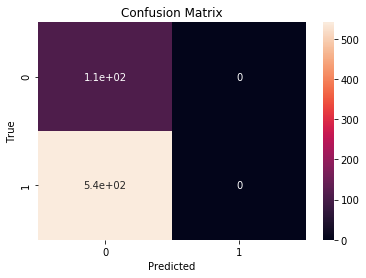

In [50]:
# Option 14

from tensorflow.keras.applications import ResNet50

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_res = ResNet50(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_res.layers[:(len(pre_model_res.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  time_callback = TimeHistory()

  # model structure
  model = Sequential([
    pre_model_res,
    layers.Flatten(),
    layers.Dense(64, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/resnet_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/resnet_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_res.append(history.history['val_accuracy'])
  val_losses_res.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/5
8/8 [==============================] - 31s 4s/step - loss: 0.9489 - accuracy: 0.6896 - val_loss: 0.9042 - val_accuracy: 0.7550
Epoch 2/5
8/8 [==============================] - 29s 4s/step - loss: 0.8820 - accuracy: 0.7559 - val_loss: 0.8614 - val_accuracy: 0.7550
Epoch 3/5
8/8 [==============================] - 29s 4s/step - loss: 0.8384 - accuracy: 0.7559 - val_loss: 0.8167 - val_accuracy: 0.7550
Epoch 4/5
8/8 [==============================] - 29s 4s/step - loss: 0.7951 - accuracy: 0.7559 - val_loss: 0.7730 - val_accuracy: 0.7550
Epoch 5/5
8/8 [==============================] - 29s 4s/step - loss: 0.7524 - accuracy: 0.7559 - val_loss: 0.7325 - val_accuracy: 0.7550
  ...
    to  
  ['...']
21/21 [==============================] - 6s 307ms/step - loss: 2.3329 - accuracy

C:\Users\server\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


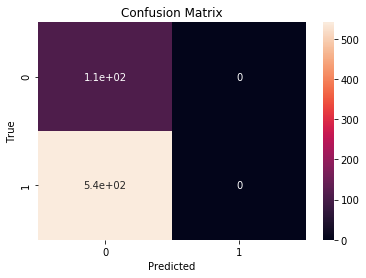

In [51]:
# Option 15

from tensorflow.keras.applications import ResNet50

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_res = ResNet50(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_res.layers[:(len(pre_model_res.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  time_callback = TimeHistory()

  # model structure
  model = Sequential([
    pre_model_res,
    layers.Flatten(),
    layers.Dense(64, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/resnet_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/resnet_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_res.append(history.history['val_accuracy'])
  val_losses_res.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/20
8/8 [==============================] - 31s 4s/step - loss: 0.3346 - accuracy: 0.8536 - val_loss: 0.5971 - val_accuracy: 0.7550
Epoch 2/20
8/8 [==============================] - 29s 4s/step - loss: 0.2033 - accuracy: 0.9312 - val_loss: 0.5960 - val_accuracy: 0.7550
Epoch 3/20
8/8 [==============================] - 29s 4s/step - loss: 0.1712 - accuracy: 0.9362 - val_loss: 0.5517 - val_accuracy: 0.7550
Epoch 4/20
8/8 [==============================] - 28s 4s/step - loss: 0.1438 - accuracy: 0.9462 - val_loss: 0.7754 - val_accuracy: 0.2550
Epoch 5/20
8/8 [==============================] - 28s 4s/step - loss: 0.1295 - accuracy: 0.9549 - val_loss: 0.7721 - val_accuracy: 0.2500
Epoch 6/20
8/8 [==============================] - 28s 4s/step - loss: 0.1209 - accuracy: 0.9625 - va

C:\Users\server\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


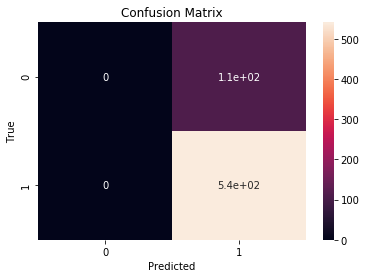

In [52]:
# Option 16

from tensorflow.keras.applications import ResNet50

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_res = ResNet50(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_res.layers[:(len(pre_model_res.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  time_callback = TimeHistory()

  # model structure
  model = Sequential([
    pre_model_res,
    layers.Flatten(),
    layers.Dense(64, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/resnet_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=20
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/resnet_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_res.append(history.history['val_accuracy'])
  val_losses_res.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


In [53]:
#avg_val_acc_res = np.mean(val_accs_res)
#avg_val_loss_res = np.mean(val_losses_res)

#print("validation accuracy is " + str(avg_val_acc_res))
#print("validation loss is " + str(avg_val_loss_res))

#avg_test_acc_res = np.mean(test_accs_res)
#avg_test_loss_res = np.mean(test_losses_res)

#print("test accuracy is " + str(avg_test_acc_res))
#print("test loss is " + str(avg_test_loss_res))


# 2.4. Xception

Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 7 steps
Epoch 1/5
25/25 [==============================] - 30s 1s/step - loss: 1.2867 - accuracy: 0.6633 - val_loss: 0.5260 - val_accuracy: 0.7550
Epoch 2/5
25/25 [==============================] - 28s 1s/step - loss: 0.4320 - accuracy: 0.7584 - val_loss: 0.5277 - val_accuracy: 0.7550
Epoch 3/5
25/25 [==============================] - 29s 1s/step - loss: 0.2669 - accuracy: 0.7947 - val_loss: 0.3635 - val_accuracy: 0.8950
Epoch 4/5
25/25 [==============================] - 28s 1s/step - loss: 0.2081 - accuracy: 0.9299 - val_loss: 0.4380 - val_accuracy: 0.8800
Epoch 5/5
25/25 [==============================] - 29s 1s/step - loss: 0.1302 - accuracy: 0.9462 - val_loss: 0.7607 - val_accuracy: 0.8200
  ...
    to  
  ['...']
21/21 [==============================] - 7s 317ms/step - loss: 6.6777

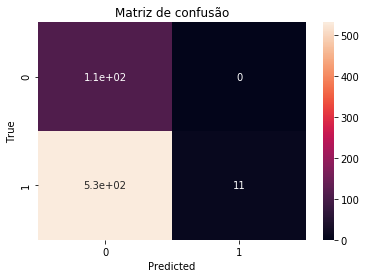

In [54]:
# Option 1

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_xcep = []
val_losses_xcep = []

test_accs_xcep = []
test_losses_xcep = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  time_callback = TimeHistory()

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/resnet_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/resnet_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_xcep.append(history.history['val_accuracy'])
  val_losses_xcep.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_xcep.append(score[1])
  test_losses_xcep.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Matriz de confusão")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 7 steps
Epoch 1/10
25/25 [==============================] - 30s 1s/step - loss: 0.8065 - accuracy: 0.7997 - val_loss: 0.5870 - val_accuracy: 0.7600
Epoch 2/10
25/25 [==============================] - 28s 1s/step - loss: 0.2719 - accuracy: 0.7897 - val_loss: 0.6068 - val_accuracy: 0.8500
Epoch 3/10
25/25 [==============================] - 28s 1s/step - loss: 0.2235 - accuracy: 0.9212 - val_loss: 0.9295 - val_accuracy: 0.9450
Epoch 4/10
25/25 [==============================] - 28s 1s/step - loss: 0.1358 - accuracy: 0.9612 - val_loss: 0.6730 - val_accuracy: 0.9300
Epoch 5/10
25/25 [==============================] - 28s 1s/step - loss: 0.0975 - accuracy: 0.9712 - val_loss: 0.4396 - val_accuracy: 0.9500
Epoch 6/10
25/25 [==============================] - 28s 1s/step - loss: 0.0757 - accuracy

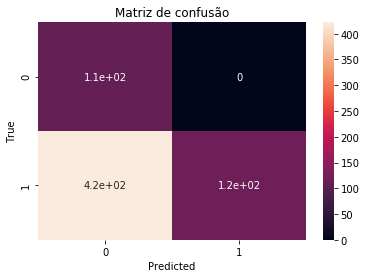

In [55]:
# Option 2

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_xcep = []
val_losses_xcep = []

test_accs_xcep = []
test_losses_xcep = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers)-10)]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  time_callback = TimeHistory()

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/resnet_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/resnet_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_xcep.append(history.history['val_accuracy'])
  val_losses_xcep.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_xcep.append(score[1])
  test_losses_xcep.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Matriz de confusão")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 7 steps
Epoch 1/10
25/25 [==============================] - 30s 1s/step - loss: 1.0091 - accuracy: 0.8385 - val_loss: 0.5601 - val_accuracy: 0.8800
Epoch 2/10
25/25 [==============================] - 28s 1s/step - loss: 0.1233 - accuracy: 0.9474 - val_loss: 0.7346 - val_accuracy: 0.9000
Epoch 3/10
25/25 [==============================] - 28s 1s/step - loss: 0.0959 - accuracy: 0.9562 - val_loss: 0.8129 - val_accuracy: 0.8500
Epoch 4/10
25/25 [==============================] - 28s 1s/step - loss: 0.0758 - accuracy: 0.9762 - val_loss: 0.9981 - val_accuracy: 0.8800
Epoch 5/10
25/25 [==============================] - 28s 1s/step - loss: 0.0514 - accuracy: 0.9862 - val_loss: 0.6830 - val_accuracy: 0.9300
Epoch 6/10
25/25 [==============================] - 28s 1s/step - loss: 0.0551 - accuracy

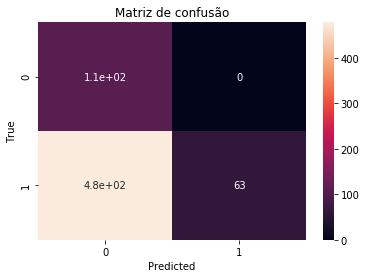

In [56]:
# Option 3

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_xcep = []
val_losses_xcep = []

test_accs_xcep = []
test_losses_xcep = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers)-5)]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  time_callback = TimeHistory()

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/resnet_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/resnet_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_xcep.append(history.history['val_accuracy'])
  val_losses_xcep.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_xcep.append(score[1])
  test_losses_xcep.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Matriz de confusão")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 7 steps
Epoch 1/10
25/25 [==============================] - 31s 1s/step - loss: 0.7122 - accuracy: 0.8335 - val_loss: 0.3528 - val_accuracy: 0.9400
Epoch 2/10
25/25 [==============================] - 29s 1s/step - loss: 0.2717 - accuracy: 0.9086 - val_loss: 0.3290 - val_accuracy: 0.9200
Epoch 3/10
25/25 [==============================] - 29s 1s/step - loss: 0.1457 - accuracy: 0.9437 - val_loss: 0.5761 - val_accuracy: 0.8950
Epoch 4/10
25/25 [==============================] - 29s 1s/step - loss: 0.1386 - accuracy: 0.9599 - val_loss: 0.5759 - val_accuracy: 0.8750
Epoch 5/10
25/25 [==============================] - 28s 1s/step - loss: 0.1247 - accuracy: 0.9549 - val_loss: 0.5946 - val_accuracy: 0.9000
Epoch 6/10
25/25 [==============================] - 29s 1s/step - loss: 0.0913 - accuracy

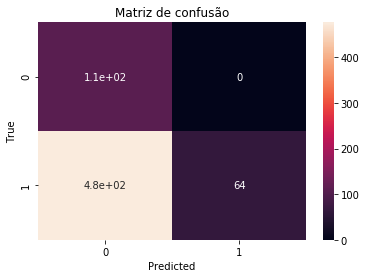

In [57]:
# Option 4

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_xcep = []
val_losses_xcep = []

test_accs_xcep = []
test_losses_xcep = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  time_callback = TimeHistory()

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/resnet_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/resnet_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_xcep.append(history.history['val_accuracy'])
  val_losses_xcep.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_xcep.append(score[1])
  test_losses_xcep.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Matriz de confusão")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/5
8/8 [==============================] - 31s 4s/step - loss: 2.8591 - accuracy: 0.6946 - val_loss: 0.6253 - val_accuracy: 0.7550
Epoch 2/5
8/8 [==============================] - 29s 4s/step - loss: 0.4760 - accuracy: 0.7559 - val_loss: 0.4732 - val_accuracy: 0.7550
Epoch 3/5
8/8 [==============================] - 29s 4s/step - loss: 0.4301 - accuracy: 0.7559 - val_loss: 0.3435 - val_accuracy: 0.7550
Epoch 4/5
8/8 [==============================] - 28s 4s/step - loss: 0.3028 - accuracy: 0.7559 - val_loss: 0.4280 - val_accuracy: 0.7550
Epoch 5/5
8/8 [==============================] - 28s 4s/step - loss: 0.2479 - accuracy: 0.7872 - val_loss: 0.7214 - val_accuracy: 0.8400
  ...
    to  
  ['...']
21/21 [==============================] - 6s 308ms/step - loss: 6.9054 - accuracy

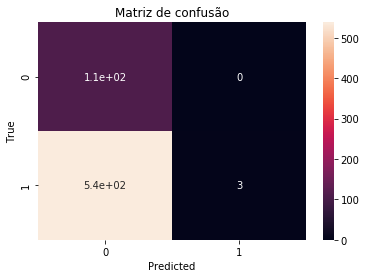

In [58]:
# Option 5

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_xcep = []
val_losses_xcep = []

test_accs_xcep = []
test_losses_xcep = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  time_callback = TimeHistory()

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/resnet_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/resnet_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_xcep.append(history.history['val_accuracy'])
  val_losses_xcep.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_xcep.append(score[1])
  test_losses_xcep.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Matriz de confusão")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/20
8/8 [==============================] - 31s 4s/step - loss: 3.5002 - accuracy: 0.5645 - val_loss: 0.6933 - val_accuracy: 0.2500
Epoch 2/20
8/8 [==============================] - 29s 4s/step - loss: 0.6926 - accuracy: 0.6646 - val_loss: 0.6921 - val_accuracy: 0.7550
Epoch 3/20
8/8 [==============================] - 29s 4s/step - loss: 0.6914 - accuracy: 0.7559 - val_loss: 0.6904 - val_accuracy: 0.7550
Epoch 4/20
8/8 [==============================] - 29s 4s/step - loss: 0.6896 - accuracy: 0.7559 - val_loss: 0.6885 - val_accuracy: 0.7550
Epoch 5/20
8/8 [==============================] - 29s 4s/step - loss: 0.6877 - accuracy: 0.7559 - val_loss: 0.6866 - val_accuracy: 0.7550
Epoch 6/20
8/8 [==============================] - 29s 4s/step - loss: 0.6858 - accuracy: 0.7559 - va

C:\Users\server\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


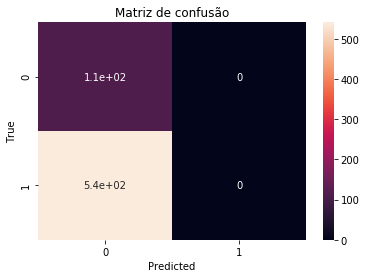

In [59]:
# Option 6

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_xcep = []
val_losses_xcep = []

test_accs_xcep = []
test_losses_xcep = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  time_callback = TimeHistory()

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/resnet_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=20
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/resnet_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_xcep.append(history.history['val_accuracy'])
  val_losses_xcep.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_xcep.append(score[1])
  test_losses_xcep.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Matriz de confusão")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 7 steps
Epoch 1/10
25/25 [==============================] - 30s 1s/step - loss: 1.3336 - accuracy: 0.7722 - val_loss: 0.4813 - val_accuracy: 0.8100
Epoch 2/10
25/25 [==============================] - 29s 1s/step - loss: 0.2308 - accuracy: 0.9111 - val_loss: 0.2918 - val_accuracy: 0.9150
Epoch 3/10
25/25 [==============================] - 29s 1s/step - loss: 0.2132 - accuracy: 0.9161 - val_loss: 0.9168 - val_accuracy: 0.8050
Epoch 4/10
25/25 [==============================] - 28s 1s/step - loss: 0.1557 - accuracy: 0.9449 - val_loss: 0.4568 - val_accuracy: 0.9100
Epoch 5/10
25/25 [==============================] - 28s 1s/step - loss: 0.1462 - accuracy: 0.9437 - val_loss: 0.5601 - val_accuracy: 0.8750
Epoch 6/10
25/25 [==============================] - 28s 1s/step - loss: 0.1130 - accuracy

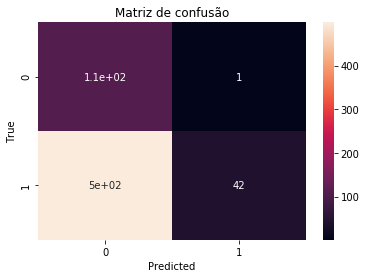

In [60]:
# Option 7

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_xcep = []
val_losses_xcep = []

test_accs_xcep = []
test_losses_xcep = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  time_callback = TimeHistory()

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/resnet_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/resnet_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_xcep.append(history.history['val_accuracy'])
  val_losses_xcep.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_xcep.append(score[1])
  test_losses_xcep.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Matriz de confusão")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/5
8/8 [==============================] - 31s 4s/step - loss: 4.7330 - accuracy: 0.6070 - val_loss: 0.6851 - val_accuracy: 0.3100
Epoch 2/5
8/8 [==============================] - 30s 4s/step - loss: 0.6149 - accuracy: 0.6170 - val_loss: 0.5085 - val_accuracy: 0.7550
Epoch 3/5
8/8 [==============================] - 30s 4s/step - loss: 0.4744 - accuracy: 0.7559 - val_loss: 0.4061 - val_accuracy: 0.7550
Epoch 4/5
8/8 [==============================] - 29s 4s/step - loss: 0.3515 - accuracy: 0.7559 - val_loss: 0.3379 - val_accuracy: 0.7550
Epoch 5/5
8/8 [==============================] - 29s 4s/step - loss: 0.2641 - accuracy: 0.7559 - val_loss: 0.4587 - val_accuracy: 0.7550
  ...
    to  
  ['...']
21/21 [==============================] - 6s 306ms/step - loss: 4.6763 - accuracy

C:\Users\server\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


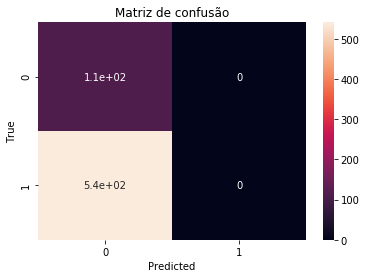

In [61]:
# Option 8

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_xcep = []
val_losses_xcep = []

test_accs_xcep = []
test_losses_xcep = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  time_callback = TimeHistory()

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/resnet_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/resnet_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_xcep.append(history.history['val_accuracy'])
  val_losses_xcep.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_xcep.append(score[1])
  test_losses_xcep.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Matriz de confusão")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/20
8/8 [==============================] - 31s 4s/step - loss: 5.8200 - accuracy: 0.6546 - val_loss: 0.6877 - val_accuracy: 0.3850
Epoch 2/20
8/8 [==============================] - 29s 4s/step - loss: 0.6925 - accuracy: 0.5069 - val_loss: 0.6915 - val_accuracy: 0.7550
Epoch 3/20
8/8 [==============================] - 29s 4s/step - loss: 0.6895 - accuracy: 0.7559 - val_loss: 0.6709 - val_accuracy: 0.7550
Epoch 4/20
8/8 [==============================] - 29s 4s/step - loss: 0.6118 - accuracy: 0.7559 - val_loss: 0.3999 - val_accuracy: 0.7550
Epoch 5/20
8/8 [==============================] - 28s 4s/step - loss: 0.4120 - accuracy: 0.7559 - val_loss: 0.6108 - val_accuracy: 0.7550
Epoch 6/20
8/8 [==============================] - 29s 4s/step - loss: 0.3997 - accuracy: 0.7559 - va

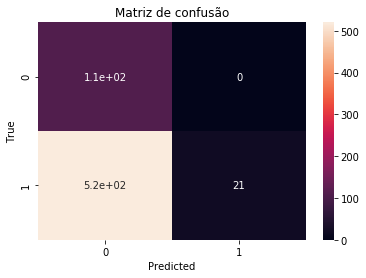

In [62]:
# Option 9

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_xcep = []
val_losses_xcep = []

test_accs_xcep = []
test_losses_xcep = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  time_callback = TimeHistory()

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/resnet_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=20
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/resnet_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_xcep.append(history.history['val_accuracy'])
  val_losses_xcep.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_xcep.append(score[1])
  test_losses_xcep.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Matriz de confusão")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 7 steps
Epoch 1/5
25/25 [==============================] - 30s 1s/step - loss: 1.0832 - accuracy: 0.7559 - val_loss: 1.0600 - val_accuracy: 0.7550
Epoch 2/5
25/25 [==============================] - 29s 1s/step - loss: 1.0066 - accuracy: 0.7559 - val_loss: 0.9640 - val_accuracy: 0.7550
Epoch 3/5
25/25 [==============================] - 29s 1s/step - loss: 0.8986 - accuracy: 0.7547 - val_loss: 0.8020 - val_accuracy: 0.7550
Epoch 4/5
25/25 [==============================] - 28s 1s/step - loss: 0.7094 - accuracy: 0.7559 - val_loss: 0.6009 - val_accuracy: 0.7500
Epoch 5/5
25/25 [==============================] - 29s 1s/step - loss: 0.5203 - accuracy: 0.7522 - val_loss: 0.4360 - val_accuracy: 0.7550
  ...
    to  
  ['...']
21/21 [==============================] - 6s 309ms/step - loss: 1.1977

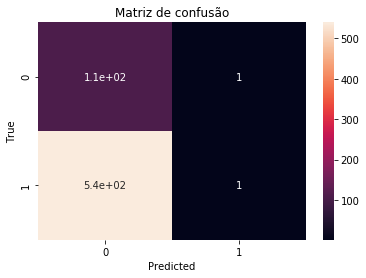

In [63]:
# Option 10

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_xcep = []
val_losses_xcep = []

test_accs_xcep = []
test_losses_xcep = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  time_callback = TimeHistory()

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/resnet_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/resnet_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_xcep.append(history.history['val_accuracy'])
  val_losses_xcep.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_xcep.append(score[1])
  test_losses_xcep.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Matriz de confusão")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 7 steps
Epoch 1/10
25/25 [==============================] - 30s 1s/step - loss: 0.5976 - accuracy: 0.7384 - val_loss: 0.4112 - val_accuracy: 0.8400
Epoch 2/10
25/25 [==============================] - 29s 1s/step - loss: 0.3254 - accuracy: 0.8636 - val_loss: 0.3621 - val_accuracy: 0.8600
Epoch 3/10
25/25 [==============================] - 29s 1s/step - loss: 0.2363 - accuracy: 0.9149 - val_loss: 0.2851 - val_accuracy: 0.9150
Epoch 4/10
25/25 [==============================] - 28s 1s/step - loss: 0.2044 - accuracy: 0.9412 - val_loss: 0.3148 - val_accuracy: 0.9050
Epoch 5/10
25/25 [==============================] - 28s 1s/step - loss: 0.1711 - accuracy: 0.9474 - val_loss: 0.2783 - val_accuracy: 0.9200
Epoch 6/10
25/25 [==============================] - 28s 1s/step - loss: 0.1588 - accuracy

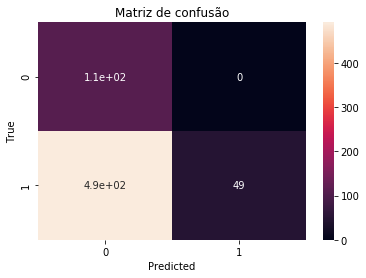

In [64]:
# Option 11

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_xcep = []
val_losses_xcep = []

test_accs_xcep = []
test_losses_xcep = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  time_callback = TimeHistory()

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/resnet_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/resnet_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_xcep.append(history.history['val_accuracy'])
  val_losses_xcep.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_xcep.append(score[1])
  test_losses_xcep.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Matriz de confusão")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/5
8/8 [==============================] - 30s 4s/step - loss: 0.7700 - accuracy: 0.6884 - val_loss: 0.7238 - val_accuracy: 0.7550
Epoch 2/5
8/8 [==============================] - 29s 4s/step - loss: 0.7141 - accuracy: 0.7559 - val_loss: 0.7083 - val_accuracy: 0.7550
Epoch 3/5
8/8 [==============================] - 29s 4s/step - loss: 0.6984 - accuracy: 0.7559 - val_loss: 0.6920 - val_accuracy: 0.7550
Epoch 4/5
8/8 [==============================] - 29s 4s/step - loss: 0.6826 - accuracy: 0.7559 - val_loss: 0.6759 - val_accuracy: 0.7550
Epoch 5/5
8/8 [==============================] - 29s 4s/step - loss: 0.6668 - accuracy: 0.7559 - val_loss: 0.6609 - val_accuracy: 0.7550
  ...
    to  
  ['...']
21/21 [==============================] - 6s 307ms/step - loss: 2.0151 - accuracy

C:\Users\server\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


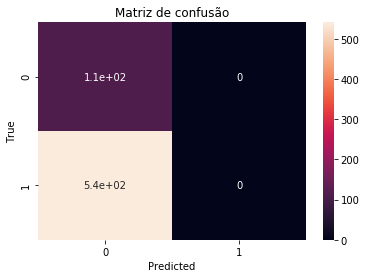

In [65]:
# Option 12

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_xcep = []
val_losses_xcep = []

test_accs_xcep = []
test_losses_xcep = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  time_callback = TimeHistory()

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/resnet_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/resnet_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_xcep.append(history.history['val_accuracy'])
  val_losses_xcep.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_xcep.append(score[1])
  test_losses_xcep.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Matriz de confusão")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/20
8/8 [==============================] - 30s 4s/step - loss: 0.7195 - accuracy: 0.6834 - val_loss: 0.6820 - val_accuracy: 0.7550
Epoch 2/20
8/8 [==============================] - 29s 4s/step - loss: 0.6741 - accuracy: 0.7559 - val_loss: 0.6679 - val_accuracy: 0.7550
Epoch 3/20
8/8 [==============================] - 29s 4s/step - loss: 0.6601 - accuracy: 0.7559 - val_loss: 0.6537 - val_accuracy: 0.7550
Epoch 4/20
8/8 [==============================] - 29s 4s/step - loss: 0.6455 - accuracy: 0.7559 - val_loss: 0.6406 - val_accuracy: 0.7550
Epoch 5/20
8/8 [==============================] - 29s 4s/step - loss: 0.6326 - accuracy: 0.7559 - val_loss: 0.6281 - val_accuracy: 0.7550
Epoch 6/20
8/8 [==============================] - 29s 4s/step - loss: 0.6210 - accuracy: 0.7559 - va

C:\Users\server\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


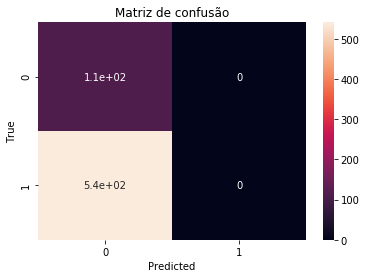

In [66]:
# Option 13

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_xcep = []
val_losses_xcep = []

test_accs_xcep = []
test_losses_xcep = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  time_callback = TimeHistory()

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/resnet_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=20
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/resnet_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_xcep.append(history.history['val_accuracy'])
  val_losses_xcep.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_xcep.append(score[1])
  test_losses_xcep.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Matriz de confusão")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 7 steps
Epoch 1/10
25/25 [==============================] - 30s 1s/step - loss: 1.0809 - accuracy: 0.7472 - val_loss: 1.0085 - val_accuracy: 0.7550
Epoch 2/10
25/25 [==============================] - 29s 1s/step - loss: 0.9142 - accuracy: 0.7559 - val_loss: 0.8310 - val_accuracy: 0.7550
Epoch 3/10
25/25 [==============================] - 29s 1s/step - loss: 0.7529 - accuracy: 0.7559 - val_loss: 0.6876 - val_accuracy: 0.7550
Epoch 4/10
25/25 [==============================] - 29s 1s/step - loss: 0.6367 - accuracy: 0.7559 - val_loss: 0.5982 - val_accuracy: 0.7550
Epoch 5/10
25/25 [==============================] - 29s 1s/step - loss: 0.5763 - accuracy: 0.7559 - val_loss: 0.5654 - val_accuracy: 0.7550
Epoch 6/10
25/25 [==============================] - 29s 1s/step - loss: 0.5588 - accuracy

C:\Users\server\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


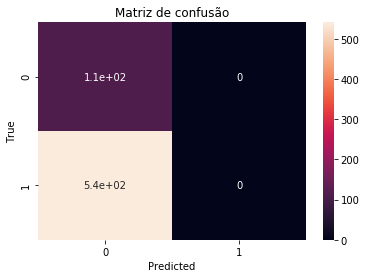

In [67]:
# Option 14

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_xcep = []
val_losses_xcep = []

test_accs_xcep = []
test_losses_xcep = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  time_callback = TimeHistory()

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(64, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/resnet_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/resnet_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_xcep.append(history.history['val_accuracy'])
  val_losses_xcep.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_xcep.append(score[1])
  test_losses_xcep.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Matriz de confusão")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/5
8/8 [==============================] - 30s 4s/step - loss: 0.9634 - accuracy: 0.7459 - val_loss: 1.0017 - val_accuracy: 0.7550
Epoch 2/5
8/8 [==============================] - 29s 4s/step - loss: 0.9735 - accuracy: 0.7559 - val_loss: 0.9462 - val_accuracy: 0.7550
Epoch 3/5
8/8 [==============================] - 29s 4s/step - loss: 0.9196 - accuracy: 0.7559 - val_loss: 0.8907 - val_accuracy: 0.7550
Epoch 4/5
8/8 [==============================] - 29s 4s/step - loss: 0.8628 - accuracy: 0.7559 - val_loss: 0.8387 - val_accuracy: 0.7550
Epoch 5/5
8/8 [==============================] - 29s 4s/step - loss: 0.8129 - accuracy: 0.7559 - val_loss: 0.7884 - val_accuracy: 0.7550
  ...
    to  
  ['...']
21/21 [==============================] - 6s 305ms/step - loss: 2.5594 - accuracy

C:\Users\server\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.17      1.00      0.29       110
           1       0.00      0.00      0.00       541

    accuracy                           0.17       651
   macro avg       0.08      0.50      0.14       651
weighted avg       0.03      0.17      0.05       651



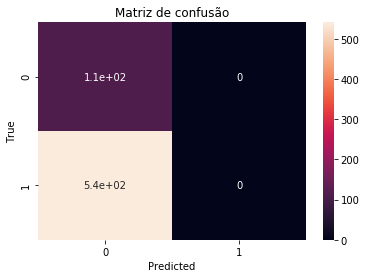

In [68]:
# Option 15

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_xcep = []
val_losses_xcep = []

test_accs_xcep = []
test_losses_xcep = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  time_callback = TimeHistory()

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(64, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/resnet_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/resnet_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_xcep.append(history.history['val_accuracy'])
  val_losses_xcep.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_xcep.append(score[1])
  test_losses_xcep.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Matriz de confusão")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


Found 799 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/20
8/8 [==============================] - 31s 4s/step - loss: 0.9704 - accuracy: 0.6834 - val_loss: 0.9450 - val_accuracy: 0.7550
Epoch 2/20
8/8 [==============================] - 29s 4s/step - loss: 0.9197 - accuracy: 0.7559 - val_loss: 0.8947 - val_accuracy: 0.7550
Epoch 3/20
8/8 [==============================] - 29s 4s/step - loss: 0.8670 - accuracy: 0.7559 - val_loss: 0.8433 - val_accuracy: 0.7550
Epoch 4/20
8/8 [==============================] - 29s 4s/step - loss: 0.8184 - accuracy: 0.7559 - val_loss: 0.7920 - val_accuracy: 0.7550
Epoch 5/20
8/8 [==============================] - 29s 4s/step - loss: 0.7689 - accuracy: 0.7559 - val_loss: 0.7447 - val_accuracy: 0.7550
Epoch 6/20
8/8 [==============================] - 29s 4s/step - loss: 0.7242 - accuracy: 0.7559 - va

C:\Users\server\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


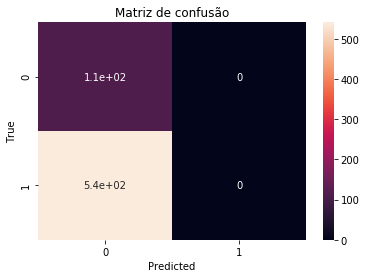

In [69]:
# Option 16

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_accs_xcep = []
val_losses_xcep = []

test_accs_xcep = []
test_losses_xcep = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(df, df['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = df.iloc[train_index]
  val_data = df.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  time_callback = TimeHistory()

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(64, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/resnet_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=20
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/resnet_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_xcep.append(history.history['val_accuracy'])
  val_losses_xcep.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_xcep.append(score[1])
  test_losses_xcep.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
  plt.title("Matriz de confusão")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  tf.keras.backend.clear_session()


In [70]:
#avg_val_acc_xcep = np.mean(val_accs_xcep)
#avg_val_loss_xcep = np.mean(val_losses_xcep)

#print("validation accuracy is " + str(avg_val_acc_xcep))
#print("validation loss is " + str(avg_val_loss_xcep))

#avg_test_acc_xcep = np.mean(test_accs_xcep)
#avg_test_loss_xcep = np.mean(test_losses_xcep)

#print("test accuracy is " + str(avg_test_acc_xcep))
#print("test loss is " + str(avg_test_loss_xcep))


# 3. 2nd experimental setting

In [117]:
# combine data

from sklearn.model_selection import train_test_split

df_com = pd.concat([df, df2])

train_com, test_com = train_test_split(df_com, test_size=0.2, random_state=7, shuffle=True)

test_datagen = image.ImageDataGenerator(rescale = 1./255)

test_ds_new = test_datagen.flow_from_dataframe(
    dataframe = test_com,
    x_col = "path",
    y_col = "label",
    target_size = (250, 250),
    color_mode = "rgb",
    class_mode = "binary",
    shuffle = False)

# test answers
LE = LabelEncoder()
y_test_new = LE.fit_transform(test_com["label"])

print(y_test_new)

Found 330 validated image filenames belonging to 2 classes.
[0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 1 1 1 1 0
 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 1 1 1 0 1 0 0 1 0 0
 1 1 0 1 1 1 1 0 1 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 0 1 0 1 0
 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 0 0 1 1 1 0 0 0 1 0 1 0 0 0
 1 0 0 0 1 0 0 1 1 1 1 1 1 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0
 1 1 1 1 0 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 0 1 0 0 1 1
 0 0 0 1 1 0 1 0 1 1 1 0 1 1 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0
 1 1 0 0 0 1 0 0 0 0 1 1 1 1 0 1 1 0 1 1 0 1 0 0 1 0 1 1 1 1 0 0 1 0 0 1 0
 1 1 1 0 0 1 1 1 1 1 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0]


# 3.1. Xception

Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 33 steps, validate for 9 steps
Epoch 1/5
33/33 [==============================] - 35s 1s/step - loss: 0.8701 - accuracy: 0.7405 - val_loss: 0.3795 - val_accuracy: 0.7955
Epoch 2/5
33/33 [==============================] - 33s 1s/step - loss: 0.2384 - accuracy: 0.9167 - val_loss: 0.4673 - val_accuracy: 0.8182
Epoch 3/5
33/33 [==============================] - 32s 960ms/step - loss: 0.1708 - accuracy: 0.9356 - val_loss: 0.5432 - val_accuracy: 0.7992
Epoch 4/5
33/33 [==============================] - 31s 950ms/step - loss: 0.1502 - accuracy: 0.9451 - val_loss: 0.4234 - val_accuracy: 0.8485
Epoch 5/5
33/33 [==============================] - 31s 950ms/step - loss: 0.1272 - accuracy: 0.9470 - val_loss: 0.6343 - val_accuracy: 0.8030
  ...
    to  
  ['...']
11/11 [==============================] - 5s 492ms/step - lo

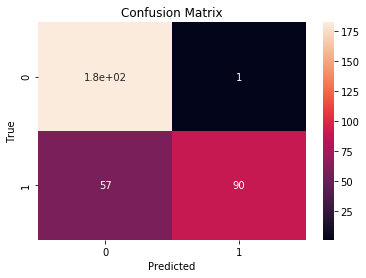

  ...
    to  
  ['...']
21/21 [==============================] - 6s 307ms/step - loss: 0.7362 - accuracy: 0.7665
Test Loss: 0.7361996989874613
Test Accuracy: 0.76651305


In [118]:
# Option 1

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 33 steps, validate for 9 steps
Epoch 1/10
33/33 [==============================] - 33s 1s/step - loss: 1.0341 - accuracy: 0.5275 - val_loss: 0.6930 - val_accuracy: 0.5189
Epoch 2/10
33/33 [==============================] - 32s 966ms/step - loss: 0.6884 - accuracy: 0.5265 - val_loss: 0.6930 - val_accuracy: 0.5189
Epoch 3/10
33/33 [==============================] - 32s 966ms/step - loss: 0.6862 - accuracy: 0.5653 - val_loss: 0.6655 - val_accuracy: 0.5720
Epoch 4/10
33/33 [==============================] - 32s 973ms/step - loss: 0.6099 - accuracy: 0.6922 - val_loss: 0.6266 - val_accuracy: 0.6136
Epoch 5/10
33/33 [==============================] - 32s 974ms/step - loss: 0.5358 - accuracy: 0.7926 - val_loss: 0.5349 - val_accuracy: 0.7500
Epoch 6/10
33/33 [==============================] - 31s 947ms/step - loss: 0

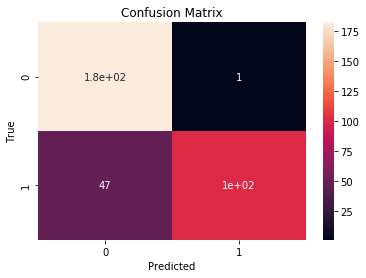

  ...
    to  
  ['...']
21/21 [==============================] - 6s 304ms/step - loss: 0.2733 - accuracy: 0.8218
Test Loss: 0.2733109692732493
Test Accuracy: 0.82181257


In [119]:
# Option 2

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 3 steps
Epoch 1/5
11/11 [==============================] - 33s 3s/step - loss: 2.3064 - accuracy: 0.6496 - val_loss: 0.1614 - val_accuracy: 0.9280
Epoch 2/5
11/11 [==============================] - 31s 3s/step - loss: 0.2937 - accuracy: 0.9044 - val_loss: 0.3159 - val_accuracy: 0.8826
Epoch 3/5
11/11 [==============================] - 31s 3s/step - loss: 0.2093 - accuracy: 0.9195 - val_loss: 0.6042 - val_accuracy: 0.8258
Epoch 4/5
11/11 [==============================] - 32s 3s/step - loss: 0.1809 - accuracy: 0.9309 - val_loss: 0.9351 - val_accuracy: 0.7727
Epoch 5/5
11/11 [==============================] - 31s 3s/step - loss: 0.1443 - accuracy: 0.9508 - val_loss: 0.7099 - val_accuracy: 0.8258
  ...
    to  
  ['...']
11/11 [==============================] - 5s 497ms/step - loss: 0.743

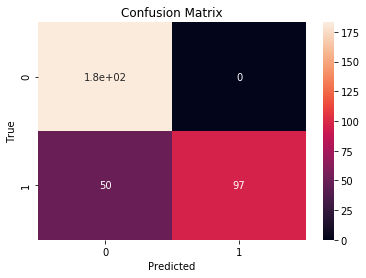

  ...
    to  
  ['...']
21/21 [==============================] - 6s 306ms/step - loss: 1.1164 - accuracy: 0.7158
Test Loss: 1.1163698179381234
Test Accuracy: 0.7158218


In [120]:
# Option 3

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 3 steps
Epoch 1/20
11/11 [==============================] - 33s 3s/step - loss: 0.8872 - accuracy: 0.7320 - val_loss: 0.9021 - val_accuracy: 0.6402
Epoch 2/20
11/11 [==============================] - 32s 3s/step - loss: 0.3356 - accuracy: 0.8636 - val_loss: 0.5605 - val_accuracy: 0.7955
Epoch 3/20
11/11 [==============================] - 31s 3s/step - loss: 0.2498 - accuracy: 0.9205 - val_loss: 0.5740 - val_accuracy: 0.7841
Epoch 4/20
11/11 [==============================] - 32s 3s/step - loss: 0.1726 - accuracy: 0.9422 - val_loss: 0.3983 - val_accuracy: 0.8750
Epoch 5/20
11/11 [==============================] - 32s 3s/step - loss: 0.1846 - accuracy: 0.9413 - val_loss: 0.1858 - val_accuracy: 0.9508
Epoch 6/20
11/11 [==============================] - 31s 3s/step - loss: 0.1398 - accurac

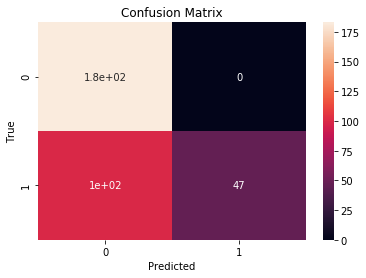

  ...
    to  
  ['...']
21/21 [==============================] - 7s 310ms/step - loss: 2.6254 - accuracy: 0.4316
Test Loss: 2.6253797099703835
Test Accuracy: 0.43164364


In [121]:
# Option 4

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=20
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 33 steps, validate for 9 steps
Epoch 1/10
33/33 [==============================] - 34s 1s/step - loss: 0.7692 - accuracy: 0.7803 - val_loss: 0.2828 - val_accuracy: 0.8902
Epoch 2/10
33/33 [==============================] - 32s 969ms/step - loss: 0.2370 - accuracy: 0.9062 - val_loss: 0.3118 - val_accuracy: 0.9053
Epoch 3/10
33/33 [==============================] - 32s 980ms/step - loss: 0.2182 - accuracy: 0.9167 - val_loss: 0.2329 - val_accuracy: 0.9167
Epoch 4/10
33/33 [==============================] - 31s 952ms/step - loss: 0.1665 - accuracy: 0.9356 - val_loss: 0.4282 - val_accuracy: 0.8523
Epoch 5/10
33/33 [==============================] - 31s 948ms/step - loss: 0.1520 - accuracy: 0.9366 - val_loss: 0.6609 - val_accuracy: 0.8220
Epoch 6/10
33/33 [==============================] - 31s 945ms/step - loss: 0

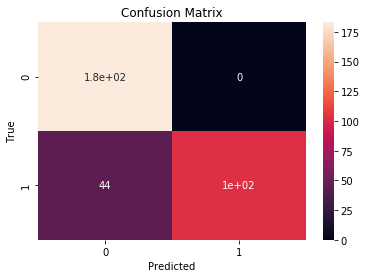

  ...
    to  
  ['...']
21/21 [==============================] - 6s 301ms/step - loss: 0.7982 - accuracy: 0.8218
Test Loss: 0.7982358677046639
Test Accuracy: 0.82181257


In [122]:
# Option 5

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 3 steps
Epoch 1/5
11/11 [==============================] - 33s 3s/step - loss: 1.8172 - accuracy: 0.6231 - val_loss: 0.2821 - val_accuracy: 0.8864
Epoch 2/5
11/11 [==============================] - 31s 3s/step - loss: 0.3895 - accuracy: 0.8381 - val_loss: 0.4353 - val_accuracy: 0.8409
Epoch 3/5
11/11 [==============================] - 31s 3s/step - loss: 0.2475 - accuracy: 0.9006 - val_loss: 0.1912 - val_accuracy: 0.9432
Epoch 4/5
11/11 [==============================] - 32s 3s/step - loss: 0.2335 - accuracy: 0.9157 - val_loss: 0.1344 - val_accuracy: 0.9545
Epoch 5/5
11/11 [==============================] - 31s 3s/step - loss: 0.2288 - accuracy: 0.9167 - val_loss: 0.1506 - val_accuracy: 0.9583
  ...
    to  
  ['...']
11/11 [==============================] - 5s 497ms/step - loss: 0.417

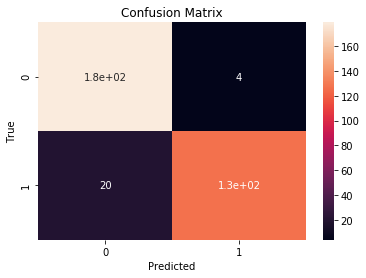

  ...
    to  
  ['...']
21/21 [==============================] - 6s 304ms/step - loss: 0.3112 - accuracy: 0.9094
Test Loss: 0.3112134179543881
Test Accuracy: 0.9093702


In [123]:
# Option 6

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 3 steps
Epoch 1/20
11/11 [==============================] - 33s 3s/step - loss: 1.3542 - accuracy: 0.7491 - val_loss: 0.2564 - val_accuracy: 0.9129
Epoch 2/20
11/11 [==============================] - 32s 3s/step - loss: 0.3013 - accuracy: 0.8930 - val_loss: 0.2308 - val_accuracy: 0.9167
Epoch 3/20
11/11 [==============================] - 31s 3s/step - loss: 0.2430 - accuracy: 0.9129 - val_loss: 0.3247 - val_accuracy: 0.9091
Epoch 4/20
11/11 [==============================] - 31s 3s/step - loss: 0.1855 - accuracy: 0.9205 - val_loss: 0.5120 - val_accuracy: 0.8712
Epoch 5/20
11/11 [==============================] - 31s 3s/step - loss: 0.1610 - accuracy: 0.9375 - val_loss: 0.7691 - val_accuracy: 0.8295
Epoch 6/20
11/11 [==============================] - 31s 3s/step - loss: 0.1252 - accurac

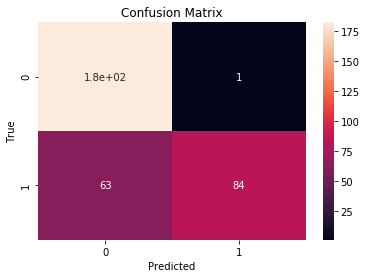

  ...
    to  
  ['...']
21/21 [==============================] - 6s 306ms/step - loss: 1.2206 - accuracy: 0.6805
Test Loss: 1.2205985358783178
Test Accuracy: 0.68049157


In [124]:
# Option 7

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=20
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 33 steps, validate for 9 steps
Epoch 1/5
33/33 [==============================] - 33s 999ms/step - loss: 0.4470 - accuracy: 0.8153 - val_loss: 0.3835 - val_accuracy: 0.8523
Epoch 2/5
33/33 [==============================] - 31s 948ms/step - loss: 0.2922 - accuracy: 0.9053 - val_loss: 0.4793 - val_accuracy: 0.7538
Epoch 3/5
33/33 [==============================] - 31s 951ms/step - loss: 0.2363 - accuracy: 0.9223 - val_loss: 0.3692 - val_accuracy: 0.8598
Epoch 4/5
33/33 [==============================] - 32s 958ms/step - loss: 0.2425 - accuracy: 0.9290 - val_loss: 0.3302 - val_accuracy: 0.8712
Epoch 5/5
33/33 [==============================] - 31s 946ms/step - loss: 0.1929 - accuracy: 0.9498 - val_loss: 0.4153 - val_accuracy: 0.8182
  ...
    to  
  ['...']
11/11 [==============================] - 5s 489ms/ste

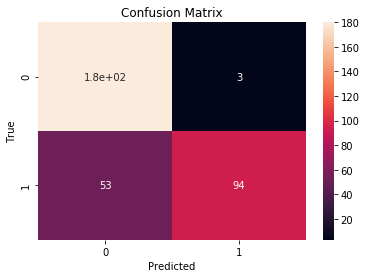

  ...
    to  
  ['...']
21/21 [==============================] - 6s 302ms/step - loss: 0.4919 - accuracy: 0.7849
Test Loss: 0.49193491680281504
Test Accuracy: 0.78494626


In [125]:
# Option 8

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 33 steps, validate for 9 steps
Epoch 1/10
33/33 [==============================] - 33s 1s/step - loss: 0.4943 - accuracy: 0.8068 - val_loss: 0.3662 - val_accuracy: 0.8485
Epoch 2/10
33/33 [==============================] - 32s 956ms/step - loss: 0.3263 - accuracy: 0.8968 - val_loss: 0.3358 - val_accuracy: 0.8561
Epoch 3/10
33/33 [==============================] - 31s 944ms/step - loss: 0.2672 - accuracy: 0.9195 - val_loss: 0.3360 - val_accuracy: 0.8295
Epoch 4/10
33/33 [==============================] - 31s 936ms/step - loss: 0.2458 - accuracy: 0.9271 - val_loss: 0.3798 - val_accuracy: 0.8220
Epoch 5/10
33/33 [==============================] - 31s 950ms/step - loss: 0.1928 - accuracy: 0.9460 - val_loss: 0.3242 - val_accuracy: 0.8561
Epoch 6/10
33/33 [==============================] - 31s 948ms/step - loss: 0

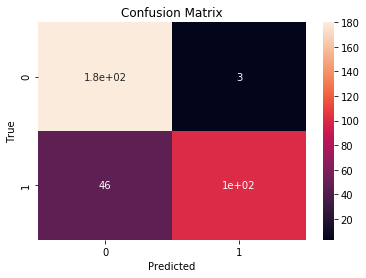

  ...
    to  
  ['...']
21/21 [==============================] - 6s 306ms/step - loss: 0.4510 - accuracy: 0.8157
Test Loss: 0.4509720170781726
Test Accuracy: 0.8156682


In [126]:
# Option 9

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 3 steps
Epoch 1/5
11/11 [==============================] - 33s 3s/step - loss: 1.2523 - accuracy: 0.4953 - val_loss: 1.2803 - val_accuracy: 0.4811
Epoch 2/5
11/11 [==============================] - 32s 3s/step - loss: 1.2579 - accuracy: 0.4839 - val_loss: 1.2253 - val_accuracy: 0.4811
Epoch 3/5
11/11 [==============================] - 32s 3s/step - loss: 1.2042 - accuracy: 0.4839 - val_loss: 1.1715 - val_accuracy: 0.4811
Epoch 4/5
11/11 [==============================] - 33s 3s/step - loss: 1.1507 - accuracy: 0.4839 - val_loss: 1.1211 - val_accuracy: 0.4811
Epoch 5/5
11/11 [==============================] - 32s 3s/step - loss: 1.1014 - accuracy: 0.4839 - val_loss: 1.0730 - val_accuracy: 0.4811
  ...
    to  
  ['...']
11/11 [==============================] - 5s 497ms/step - loss: 1.167

C:\Users\server\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


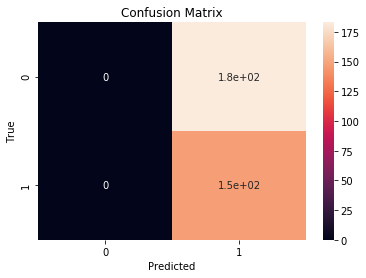

  ...
    to  
  ['...']
21/21 [==============================] - 6s 302ms/step - loss: 0.4572 - accuracy: 0.8310
Test Loss: 0.4571561784971328
Test Accuracy: 0.8310292


In [127]:
# Option 10

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 3 steps
Epoch 1/20
11/11 [==============================] - 33s 3s/step - loss: 1.4410 - accuracy: 0.4782 - val_loss: 1.4723 - val_accuracy: 0.4811
Epoch 2/20
11/11 [==============================] - 32s 3s/step - loss: 1.4183 - accuracy: 0.4839 - val_loss: 1.4031 - val_accuracy: 0.4811
Epoch 3/20
11/11 [==============================] - 32s 3s/step - loss: 1.3510 - accuracy: 0.4839 - val_loss: 1.3354 - val_accuracy: 0.4811
Epoch 4/20
11/11 [==============================] - 32s 3s/step - loss: 1.2859 - accuracy: 0.4839 - val_loss: 1.2700 - val_accuracy: 0.4811
Epoch 5/20
11/11 [==============================] - 32s 3s/step - loss: 1.2232 - accuracy: 0.4839 - val_loss: 1.2075 - val_accuracy: 0.4811
Epoch 6/20
11/11 [==============================] - 32s 3s/step - loss: 1.1637 - accurac

C:\Users\server\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


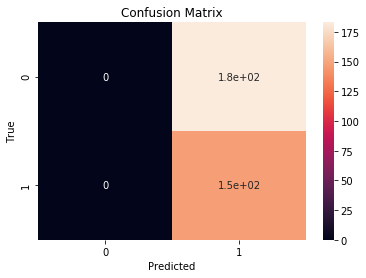

  ...
    to  
  ['...']
21/21 [==============================] - 6s 305ms/step - loss: 0.5767 - accuracy: 0.8310
Test Loss: 0.5766602045013791
Test Accuracy: 0.8310292


In [128]:
# Option 11

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=20
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 33 steps, validate for 9 steps
Epoch 1/10
33/33 [==============================] - 33s 1s/step - loss: 1.0253 - accuracy: 0.6241 - val_loss: 0.5610 - val_accuracy: 0.7386
Epoch 2/10
33/33 [==============================] - 32s 974ms/step - loss: 0.4151 - accuracy: 0.8627 - val_loss: 0.4123 - val_accuracy: 0.8788
Epoch 3/10
33/33 [==============================] - 32s 966ms/step - loss: 0.2814 - accuracy: 0.9205 - val_loss: 0.3280 - val_accuracy: 0.8788
Epoch 4/10
33/33 [==============================] - 31s 947ms/step - loss: 0.2320 - accuracy: 0.9299 - val_loss: 0.3445 - val_accuracy: 0.8561
Epoch 5/10
33/33 [==============================] - 32s 964ms/step - loss: 0.2033 - accuracy: 0.9394 - val_loss: 0.2876 - val_accuracy: 0.8977
Epoch 6/10
33/33 [==============================] - 32s 973ms/step - loss: 0

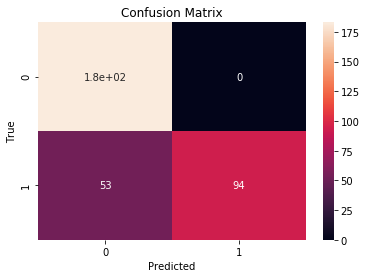

  ...
    to  
  ['...']
21/21 [==============================] - 6s 303ms/step - loss: 0.4868 - accuracy: 0.7788
Test Loss: 0.48675753956749324
Test Accuracy: 0.77880186


In [129]:
# Option 12

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(64, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 3 steps
Epoch 1/5
11/11 [==============================] - 33s 3s/step - loss: 1.9420 - accuracy: 0.4725 - val_loss: 1.9459 - val_accuracy: 0.4811
Epoch 2/5
11/11 [==============================] - 32s 3s/step - loss: 1.8705 - accuracy: 0.4839 - val_loss: 1.7635 - val_accuracy: 0.4811
Epoch 3/5
11/11 [==============================] - 32s 3s/step - loss: 1.5918 - accuracy: 0.4839 - val_loss: 1.4408 - val_accuracy: 0.4811
Epoch 4/5
11/11 [==============================] - 32s 3s/step - loss: 1.2673 - accuracy: 0.4839 - val_loss: 1.1299 - val_accuracy: 0.4811
Epoch 5/5
11/11 [==============================] - 32s 3s/step - loss: 1.0096 - accuracy: 0.4839 - val_loss: 0.9149 - val_accuracy: 0.4811
  ...
    to  
  ['...']
11/11 [==============================] - 6s 503ms/step - loss: 0.985

C:\Users\server\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


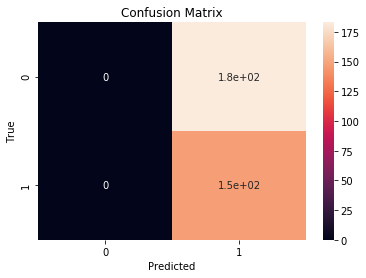

  ...
    to  
  ['...']
21/21 [==============================] - 6s 305ms/step - loss: 0.4522 - accuracy: 0.8310
Test Loss: 0.4521832593849727
Test Accuracy: 0.8310292


In [130]:
# Option 13

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(64, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 3 steps
Epoch 1/20
11/11 [==============================] - 33s 3s/step - loss: 1.4781 - accuracy: 0.4839 - val_loss: 1.4838 - val_accuracy: 0.4811
Epoch 2/20
11/11 [==============================] - 32s 3s/step - loss: 1.4035 - accuracy: 0.4839 - val_loss: 1.3566 - val_accuracy: 0.4811
Epoch 3/20
11/11 [==============================] - 32s 3s/step - loss: 1.2820 - accuracy: 0.4839 - val_loss: 1.2353 - val_accuracy: 0.4811
Epoch 4/20
11/11 [==============================] - 32s 3s/step - loss: 1.1657 - accuracy: 0.4839 - val_loss: 1.1255 - val_accuracy: 0.4811
Epoch 5/20
11/11 [==============================] - 32s 3s/step - loss: 1.0642 - accuracy: 0.4839 - val_loss: 1.0263 - val_accuracy: 0.4811
Epoch 6/20
11/11 [==============================] - 32s 3s/step - loss: 0.9750 - accurac

C:\Users\server\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


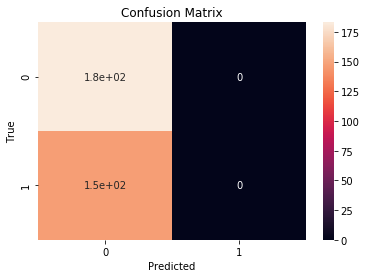

  ...
    to  
  ['...']
21/21 [==============================] - 6s 303ms/step - loss: 0.7083 - accuracy: 0.1690
Test Loss: 0.7082650065422058
Test Accuracy: 0.16897081


In [131]:
# Option 14

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(64, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=20
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 33 steps, validate for 9 steps
Epoch 1/5
33/33 [==============================] - 33s 1s/step - loss: 0.4623 - accuracy: 0.8551 - val_loss: 0.5523 - val_accuracy: 0.9129
Epoch 2/5
33/33 [==============================] - 31s 949ms/step - loss: 0.4293 - accuracy: 0.8854 - val_loss: 1.4425 - val_accuracy: 0.8144
Epoch 3/5
33/33 [==============================] - 31s 947ms/step - loss: 0.2618 - accuracy: 0.9290 - val_loss: 1.8220 - val_accuracy: 0.7727
Epoch 4/5
33/33 [==============================] - 31s 940ms/step - loss: 0.2414 - accuracy: 0.9347 - val_loss: 0.8502 - val_accuracy: 0.8864
Epoch 5/5
33/33 [==============================] - 31s 952ms/step - loss: 0.3354 - accuracy: 0.9110 - val_loss: 1.4801 - val_accuracy: 0.8333
  ...
    to  
  ['...']
11/11 [==============================] - 5s 492ms/step -

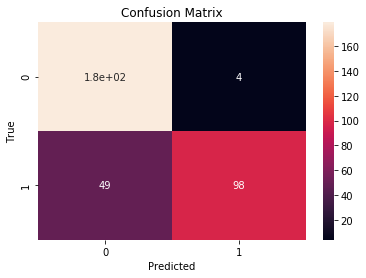

  ...
    to  
  ['...']
21/21 [==============================] - 6s 308ms/step - loss: 2.0718 - accuracy: 0.7343
Test Loss: 2.0718381078470323
Test Accuracy: 0.734255


In [132]:
# Option 15

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 33 steps, validate for 9 steps
Epoch 1/10
33/33 [==============================] - 33s 1s/step - loss: 0.5875 - accuracy: 0.8286 - val_loss: 0.4331 - val_accuracy: 0.8977
Epoch 2/10
33/33 [==============================] - 31s 953ms/step - loss: 0.3387 - accuracy: 0.9176 - val_loss: 1.1066 - val_accuracy: 0.7727
Epoch 3/10
33/33 [==============================] - 31s 949ms/step - loss: 0.2277 - accuracy: 0.9328 - val_loss: 0.9329 - val_accuracy: 0.8295
Epoch 4/10
33/33 [==============================] - 31s 948ms/step - loss: 0.2908 - accuracy: 0.9167 - val_loss: 1.3784 - val_accuracy: 0.7841
Epoch 5/10
33/33 [==============================] - 31s 945ms/step - loss: 0.2231 - accuracy: 0.9299 - val_loss: 2.8344 - val_accuracy: 0.6667
Epoch 6/10
33/33 [==============================] - 31s 946ms/step - loss: 0

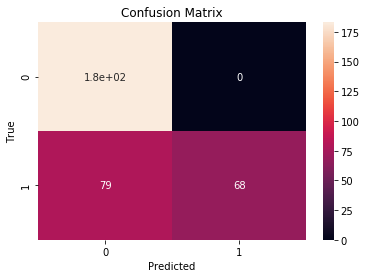

  ...
    to  
  ['...']
21/21 [==============================] - 6s 306ms/step - loss: 2.5484 - accuracy: 0.6943
Test Loss: 2.5484326368286494
Test Accuracy: 0.69431645


In [133]:
# Option 16

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 33 steps, validate for 9 steps
Epoch 1/20
33/33 [==============================] - 33s 1s/step - loss: 1.0809 - accuracy: 0.7652 - val_loss: 1.4195 - val_accuracy: 0.7348
Epoch 2/20
33/33 [==============================] - 32s 960ms/step - loss: 0.3941 - accuracy: 0.9081 - val_loss: 0.8872 - val_accuracy: 0.8030
Epoch 3/20
33/33 [==============================] - 32s 960ms/step - loss: 0.2624 - accuracy: 0.9252 - val_loss: 0.3003 - val_accuracy: 0.9280
Epoch 4/20
33/33 [==============================] - 32s 961ms/step - loss: 0.2730 - accuracy: 0.9195 - val_loss: 0.7588 - val_accuracy: 0.8636
Epoch 5/20
33/33 [==============================] - 31s 945ms/step - loss: 0.2139 - accuracy: 0.9366 - val_loss: 0.5736 - val_accuracy: 0.9167
Epoch 6/20
33/33 [==============================] - 31s 946ms/step - loss: 0

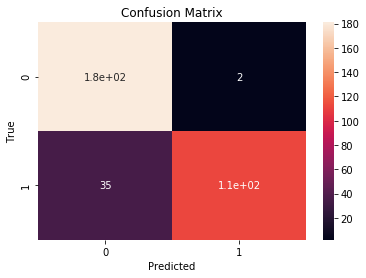

  ...
    to  
  ['...']
21/21 [==============================] - 6s 303ms/step - loss: 1.2473 - accuracy: 0.8710
Test Loss: 1.2472966785232227
Test Accuracy: 0.87096775


In [134]:
# Option 17

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=20
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 3 steps
Epoch 1/5
11/11 [==============================] - 33s 3s/step - loss: 1.3659 - accuracy: 0.6648 - val_loss: 0.2489 - val_accuracy: 0.9205
Epoch 2/5
11/11 [==============================] - 32s 3s/step - loss: 0.6916 - accuracy: 0.8277 - val_loss: 1.2769 - val_accuracy: 0.7727
Epoch 3/5
11/11 [==============================] - 31s 3s/step - loss: 0.3936 - accuracy: 0.9186 - val_loss: 2.2432 - val_accuracy: 0.7121
Epoch 4/5
11/11 [==============================] - 31s 3s/step - loss: 0.3652 - accuracy: 0.8968 - val_loss: 0.4385 - val_accuracy: 0.9053
Epoch 5/5
11/11 [==============================] - 31s 3s/step - loss: 0.2584 - accuracy: 0.9337 - val_loss: 0.6380 - val_accuracy: 0.8674
  ...
    to  
  ['...']
11/11 [==============================] - 6s 505ms/step - loss: 0.948

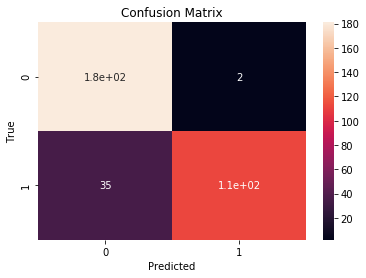

  ...
    to  
  ['...']
21/21 [==============================] - 6s 301ms/step - loss: 0.8926 - accuracy: 0.8525
Test Loss: 0.8926383382862523
Test Accuracy: 0.85253453


In [135]:
# Option 18

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 3 steps
Epoch 1/10
11/11 [==============================] - 33s 3s/step - loss: 0.7641 - accuracy: 0.7585 - val_loss: 0.7511 - val_accuracy: 0.8106
Epoch 2/10
11/11 [==============================] - 31s 3s/step - loss: 0.2948 - accuracy: 0.9186 - val_loss: 0.7715 - val_accuracy: 0.8409
Epoch 3/10
11/11 [==============================] - 32s 3s/step - loss: 0.2274 - accuracy: 0.9252 - val_loss: 0.6373 - val_accuracy: 0.8712
Epoch 4/10
11/11 [==============================] - 32s 3s/step - loss: 0.2000 - accuracy: 0.9328 - val_loss: 0.3111 - val_accuracy: 0.9205
Epoch 5/10
11/11 [==============================] - 32s 3s/step - loss: 0.2096 - accuracy: 0.9366 - val_loss: 0.2850 - val_accuracy: 0.9318
Epoch 6/10
11/11 [==============================] - 32s 3s/step - loss: 0.1633 - accurac

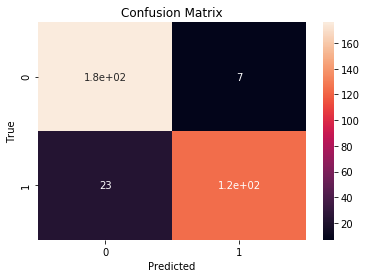

  ...
    to  
  ['...']
21/21 [==============================] - 6s 305ms/step - loss: 0.4597 - accuracy: 0.9124
Test Loss: 0.4596772630299841
Test Accuracy: 0.9124424


In [136]:
# Option 19

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 3 steps
Epoch 1/20
11/11 [==============================] - 33s 3s/step - loss: 1.3119 - accuracy: 0.6932 - val_loss: 0.2049 - val_accuracy: 0.9394
Epoch 2/20
11/11 [==============================] - 31s 3s/step - loss: 0.3209 - accuracy: 0.8939 - val_loss: 0.8871 - val_accuracy: 0.8333
Epoch 3/20
11/11 [==============================] - 31s 3s/step - loss: 0.2070 - accuracy: 0.9356 - val_loss: 1.8663 - val_accuracy: 0.7045
Epoch 4/20
11/11 [==============================] - 31s 3s/step - loss: 0.1778 - accuracy: 0.9403 - val_loss: 1.5224 - val_accuracy: 0.7273
Epoch 5/20
11/11 [==============================] - 31s 3s/step - loss: 0.1728 - accuracy: 0.9394 - val_loss: 0.8826 - val_accuracy: 0.8485
Epoch 6/20
11/11 [==============================] - 31s 3s/step - loss: 0.2261 - accurac

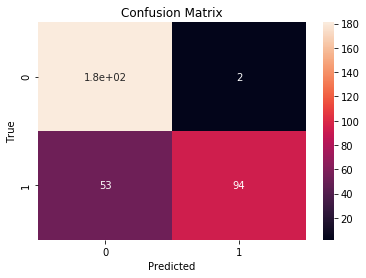

  ...
    to  
  ['...']
21/21 [==============================] - 6s 305ms/step - loss: 1.0885 - accuracy: 0.7926
Test Loss: 1.08854236134461
Test Accuracy: 0.79262674


In [137]:
# Option 20

from tensorflow.keras.applications import Xception

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

input = Input(shape=(250,250,3))
pre_model_xcep = Xception(include_top=False, weights='imagenet', input_tensor=input)

# freeze
for i in pre_model_xcep.layers[:(len(pre_model_xcep.layers))]:
  i.trainable=False

for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model

  num_classes = 2

  # model structure
  model = Sequential([
    pre_model_xcep,
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
    ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=20
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


# 3.2. Own model

Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 33 steps, validate for 9 steps
Epoch 1/5
33/33 [==============================] - 32s 958ms/step - loss: 0.6572 - accuracy: 0.6809 - val_loss: 0.4478 - val_accuracy: 0.8030
Epoch 2/5
33/33 [==============================] - 32s 978ms/step - loss: 0.4084 - accuracy: 0.8229 - val_loss: 0.3433 - val_accuracy: 0.8409
Epoch 3/5
33/33 [==============================] - 31s 946ms/step - loss: 0.3327 - accuracy: 0.8750 - val_loss: 0.2893 - val_accuracy: 0.8902
Epoch 4/5
33/33 [==============================] - 31s 942ms/step - loss: 0.3719 - accuracy: 0.8400 - val_loss: 0.2795 - val_accuracy: 0.8864
Epoch 5/5
33/33 [==============================] - 31s 941ms/step - loss: 0.3314 - accuracy: 0.8627 - val_loss: 0.2977 - val_accuracy: 0.8674
  ...
    to  
  ['...']
11/11 [==============================] - 5s 486ms/ste

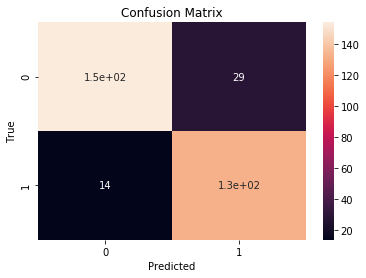

  ...
    to  
  ['...']
21/21 [==============================] - 6s 305ms/step - loss: 0.2681 - accuracy: 0.8955
Test Loss: 0.26811110760484425
Test Accuracy: 0.8955453


In [138]:
# Option 1

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)


for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 33 steps, validate for 9 steps
Epoch 1/10
33/33 [==============================] - 31s 951ms/step - loss: 0.5216 - accuracy: 0.7604 - val_loss: 0.5656 - val_accuracy: 0.7576
Epoch 2/10
33/33 [==============================] - 31s 936ms/step - loss: 0.3612 - accuracy: 0.8532 - val_loss: 0.5938 - val_accuracy: 0.7462
Epoch 3/10
33/33 [==============================] - 31s 942ms/step - loss: 0.3183 - accuracy: 0.8665 - val_loss: 0.3392 - val_accuracy: 0.8750
Epoch 4/10
33/33 [==============================] - 31s 940ms/step - loss: 0.3189 - accuracy: 0.8769 - val_loss: 0.3622 - val_accuracy: 0.8409
Epoch 5/10
33/33 [==============================] - 31s 939ms/step - loss: 0.2808 - accuracy: 0.8854 - val_loss: 0.3765 - val_accuracy: 0.8182
Epoch 6/10
33/33 [==============================] - 31s 936ms/step - loss

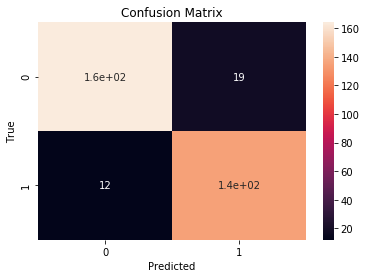

  ...
    to  
  ['...']
21/21 [==============================] - 6s 297ms/step - loss: 0.2193 - accuracy: 0.9109
Test Loss: 0.2192555172812371
Test Accuracy: 0.9109063


In [139]:
# Option 2

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)


for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 33 steps, validate for 9 steps
Epoch 1/20
33/33 [==============================] - 32s 956ms/step - loss: 0.7459 - accuracy: 0.6212 - val_loss: 0.4001 - val_accuracy: 0.7992
Epoch 2/20
33/33 [==============================] - 31s 949ms/step - loss: 0.4493 - accuracy: 0.8220 - val_loss: 0.3018 - val_accuracy: 0.8523
Epoch 3/20
33/33 [==============================] - 31s 940ms/step - loss: 0.3420 - accuracy: 0.8674 - val_loss: 0.3591 - val_accuracy: 0.8371
Epoch 4/20
33/33 [==============================] - 31s 944ms/step - loss: 0.3166 - accuracy: 0.8741 - val_loss: 0.3016 - val_accuracy: 0.8712
Epoch 5/20
33/33 [==============================] - 31s 948ms/step - loss: 0.2894 - accuracy: 0.8797 - val_loss: 0.2965 - val_accuracy: 0.8561
Epoch 6/20
33/33 [==============================] - 31s 943ms/step - loss

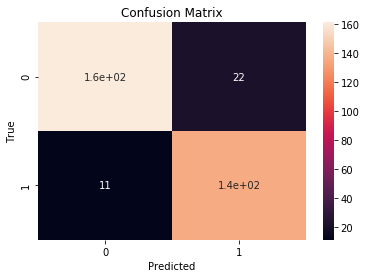

  ...
    to  
  ['...']
21/21 [==============================] - 6s 300ms/step - loss: 0.1885 - accuracy: 0.9155
Test Loss: 0.18847428102578437
Test Accuracy: 0.9155146


In [140]:
# Option 3

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)


for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=20
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 3 steps
Epoch 1/5
11/11 [==============================] - 31s 3s/step - loss: 0.7300 - accuracy: 0.6733 - val_loss: 0.5956 - val_accuracy: 0.7083
Epoch 2/5
11/11 [==============================] - 32s 3s/step - loss: 0.4388 - accuracy: 0.8134 - val_loss: 0.5549 - val_accuracy: 0.7689
Epoch 3/5
11/11 [==============================] - 31s 3s/step - loss: 0.3587 - accuracy: 0.8494 - val_loss: 0.4103 - val_accuracy: 0.8106
Epoch 4/5
11/11 [==============================] - 31s 3s/step - loss: 0.3234 - accuracy: 0.8731 - val_loss: 0.3243 - val_accuracy: 0.8674
Epoch 5/5
11/11 [==============================] - 31s 3s/step - loss: 0.2952 - accuracy: 0.8892 - val_loss: 0.2982 - val_accuracy: 0.8750
  ...
    to  
  ['...']
11/11 [==============================] - 5s 494ms/step - loss: 0.245

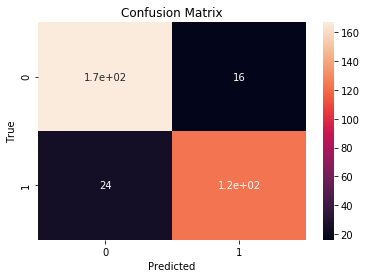

  ...
    to  
  ['...']
21/21 [==============================] - 6s 297ms/step - loss: 0.3694 - accuracy: 0.8356
Test Loss: 0.36944338360003065
Test Accuracy: 0.8356375


In [141]:
# Option 4

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)


for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 3 steps
Epoch 1/10
11/11 [==============================] - 31s 3s/step - loss: 0.9845 - accuracy: 0.5407 - val_loss: 0.5956 - val_accuracy: 0.7386
Epoch 2/10
11/11 [==============================] - 31s 3s/step - loss: 0.5115 - accuracy: 0.7727 - val_loss: 0.4326 - val_accuracy: 0.7917
Epoch 3/10
11/11 [==============================] - 31s 3s/step - loss: 0.4151 - accuracy: 0.8258 - val_loss: 0.3681 - val_accuracy: 0.8598
Epoch 4/10
11/11 [==============================] - 31s 3s/step - loss: 0.4096 - accuracy: 0.8362 - val_loss: 0.3214 - val_accuracy: 0.8636
Epoch 5/10
11/11 [==============================] - 31s 3s/step - loss: 0.3507 - accuracy: 0.8523 - val_loss: 0.2916 - val_accuracy: 0.8902
Epoch 6/10
11/11 [==============================] - 31s 3s/step - loss: 0.3312 - accurac

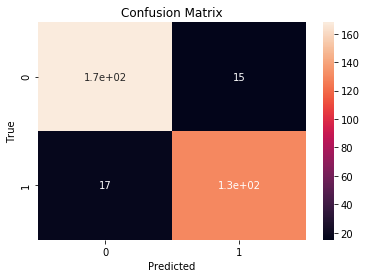

  ...
    to  
  ['...']
21/21 [==============================] - 6s 298ms/step - loss: 0.3248 - accuracy: 0.8587
Test Loss: 0.3247820004111245
Test Accuracy: 0.85867894


In [142]:
# Option 5

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)


for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 3 steps
Epoch 1/20
11/11 [==============================] - 31s 3s/step - loss: 1.1395 - accuracy: 0.6042 - val_loss: 0.6011 - val_accuracy: 0.7576
Epoch 2/20
11/11 [==============================] - 31s 3s/step - loss: 0.4800 - accuracy: 0.7841 - val_loss: 0.4534 - val_accuracy: 0.7992
Epoch 3/20
11/11 [==============================] - 31s 3s/step - loss: 0.4044 - accuracy: 0.8362 - val_loss: 0.4103 - val_accuracy: 0.8068
Epoch 4/20
11/11 [==============================] - 31s 3s/step - loss: 0.3387 - accuracy: 0.8617 - val_loss: 0.4086 - val_accuracy: 0.8258
Epoch 5/20
11/11 [==============================] - 31s 3s/step - loss: 0.3203 - accuracy: 0.8731 - val_loss: 0.4890 - val_accuracy: 0.8144
Epoch 6/20
11/11 [==============================] - 31s 3s/step - loss: 0.3478 - accurac

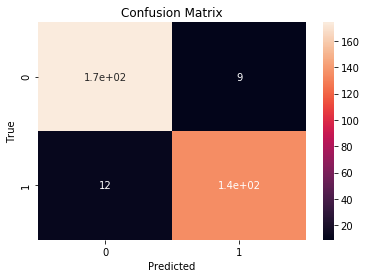

  ...
    to  
  ['...']
21/21 [==============================] - 6s 301ms/step - loss: 0.2531 - accuracy: 0.9048
Test Loss: 0.25314242037988843
Test Accuracy: 0.9047619


In [143]:
# Option 6

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)


for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=20
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 33 steps, validate for 9 steps
Epoch 1/5
33/33 [==============================] - 31s 954ms/step - loss: 0.5924 - accuracy: 0.7538 - val_loss: 0.3651 - val_accuracy: 0.8523
Epoch 2/5
33/33 [==============================] - 31s 945ms/step - loss: 0.3573 - accuracy: 0.8504 - val_loss: 0.2928 - val_accuracy: 0.8561
Epoch 3/5
33/33 [==============================] - 31s 942ms/step - loss: 0.3210 - accuracy: 0.8513 - val_loss: 0.2844 - val_accuracy: 0.8864
Epoch 4/5
33/33 [==============================] - 31s 943ms/step - loss: 0.2984 - accuracy: 0.8778 - val_loss: 0.3017 - val_accuracy: 0.8674
Epoch 5/5
33/33 [==============================] - 31s 936ms/step - loss: 0.2885 - accuracy: 0.8826 - val_loss: 0.3221 - val_accuracy: 0.8485
  ...
    to  
  ['...']
11/11 [==============================] - 5s 484ms/ste

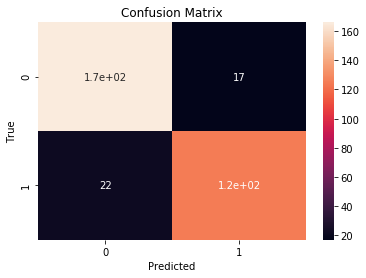

  ...
    to  
  ['...']
21/21 [==============================] - 6s 299ms/step - loss: 0.3840 - accuracy: 0.8372
Test Loss: 0.3840303974492209
Test Accuracy: 0.8371736


In [144]:
# Option 7

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)


for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 33 steps, validate for 9 steps
Epoch 1/10
33/33 [==============================] - 32s 958ms/step - loss: 0.5276 - accuracy: 0.7699 - val_loss: 0.4099 - val_accuracy: 0.8409
Epoch 2/10
33/33 [==============================] - 31s 951ms/step - loss: 0.3719 - accuracy: 0.8428 - val_loss: 0.3625 - val_accuracy: 0.8485
Epoch 3/10
33/33 [==============================] - 31s 939ms/step - loss: 0.3195 - accuracy: 0.8674 - val_loss: 0.4381 - val_accuracy: 0.8333
Epoch 4/10
33/33 [==============================] - 31s 935ms/step - loss: 0.2855 - accuracy: 0.8845 - val_loss: 0.3727 - val_accuracy: 0.8485
Epoch 5/10
33/33 [==============================] - 31s 939ms/step - loss: 0.2875 - accuracy: 0.8807 - val_loss: 0.3425 - val_accuracy: 0.8636
Epoch 6/10
33/33 [==============================] - 31s 946ms/step - loss

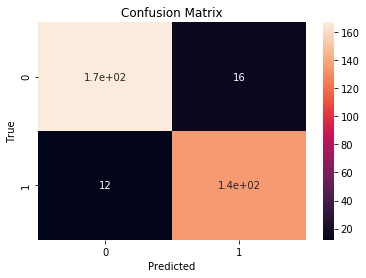

  ...
    to  
  ['...']
21/21 [==============================] - 6s 299ms/step - loss: 0.2541 - accuracy: 0.9032
Test Loss: 0.2541466216955866
Test Accuracy: 0.9032258


In [145]:
# Option 8

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)


for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 33 steps, validate for 9 steps
Epoch 1/20
33/33 [==============================] - 31s 953ms/step - loss: 0.6612 - accuracy: 0.6733 - val_loss: 0.3994 - val_accuracy: 0.8144
Epoch 2/20
33/33 [==============================] - 31s 948ms/step - loss: 0.3943 - accuracy: 0.8305 - val_loss: 0.2982 - val_accuracy: 0.8409
Epoch 3/20
33/33 [==============================] - 31s 942ms/step - loss: 0.3349 - accuracy: 0.8598 - val_loss: 0.4868 - val_accuracy: 0.7803
Epoch 4/20
33/33 [==============================] - 31s 937ms/step - loss: 0.2972 - accuracy: 0.8788 - val_loss: 0.3749 - val_accuracy: 0.8561
Epoch 5/20
33/33 [==============================] - 31s 936ms/step - loss: 0.3005 - accuracy: 0.8816 - val_loss: 0.3179 - val_accuracy: 0.8636
Epoch 6/20
33/33 [==============================] - 31s 942ms/step - loss

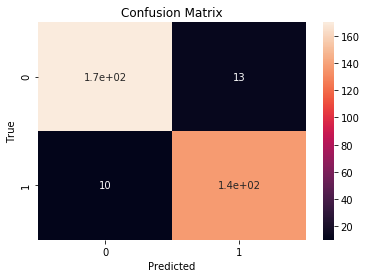

  ...
    to  
  ['...']
21/21 [==============================] - 6s 299ms/step - loss: 0.1488 - accuracy: 0.9493
Test Loss: 0.14877317162851492
Test Accuracy: 0.94930875


In [146]:
# Option 9

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)


for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=20
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 3 steps
Epoch 1/5
11/11 [==============================] - 31s 3s/step - loss: 1.5229 - accuracy: 0.5246 - val_loss: 0.6985 - val_accuracy: 0.5189
Epoch 2/5
11/11 [==============================] - 31s 3s/step - loss: 0.6565 - accuracy: 0.5748 - val_loss: 0.6002 - val_accuracy: 0.7992
Epoch 3/5
11/11 [==============================] - 31s 3s/step - loss: 0.5125 - accuracy: 0.8011 - val_loss: 0.4432 - val_accuracy: 0.8144
Epoch 4/5
11/11 [==============================] - 31s 3s/step - loss: 0.4311 - accuracy: 0.8106 - val_loss: 0.4606 - val_accuracy: 0.8068
Epoch 5/5
11/11 [==============================] - 31s 3s/step - loss: 0.3557 - accuracy: 0.8617 - val_loss: 0.4310 - val_accuracy: 0.7879
  ...
    to  
  ['...']
11/11 [==============================] - 6s 502ms/step - loss: 0.375

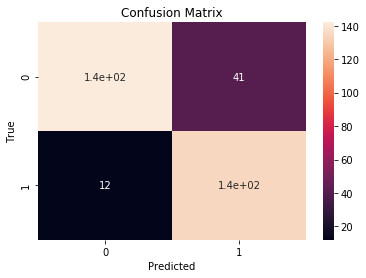

  ...
    to  
  ['...']
21/21 [==============================] - 6s 298ms/step - loss: 0.3088 - accuracy: 0.8679
Test Loss: 0.30875459987492787
Test Accuracy: 0.86789554


In [147]:
# Option 10

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)


for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 3 steps
Epoch 1/10
11/11 [==============================] - 31s 3s/step - loss: 0.9107 - accuracy: 0.5047 - val_loss: 0.6778 - val_accuracy: 0.5189
Epoch 2/10
11/11 [==============================] - 31s 3s/step - loss: 0.5932 - accuracy: 0.6525 - val_loss: 0.4888 - val_accuracy: 0.7576
Epoch 3/10
11/11 [==============================] - 31s 3s/step - loss: 0.4475 - accuracy: 0.8068 - val_loss: 0.3152 - val_accuracy: 0.8523
Epoch 4/10
11/11 [==============================] - 31s 3s/step - loss: 0.4112 - accuracy: 0.8248 - val_loss: 0.3769 - val_accuracy: 0.8371
Epoch 5/10
11/11 [==============================] - 31s 3s/step - loss: 0.3644 - accuracy: 0.8419 - val_loss: 0.2705 - val_accuracy: 0.8902
Epoch 6/10
11/11 [==============================] - 31s 3s/step - loss: 0.3290 - accurac

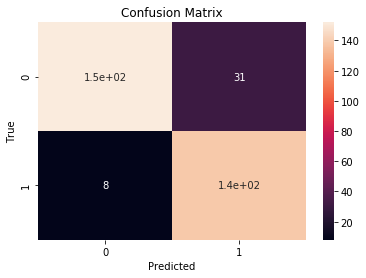

  ...
    to  
  ['...']
21/21 [==============================] - 6s 296ms/step - loss: 0.2673 - accuracy: 0.9032
Test Loss: 0.26729887688443776
Test Accuracy: 0.9032258


In [148]:
# Option 11

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)


for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 3 steps
Epoch 1/20
11/11 [==============================] - 31s 3s/step - loss: 0.8412 - accuracy: 0.7036 - val_loss: 0.4451 - val_accuracy: 0.7992
Epoch 2/20
11/11 [==============================] - 31s 3s/step - loss: 0.4310 - accuracy: 0.8229 - val_loss: 0.4199 - val_accuracy: 0.8144
Epoch 3/20
11/11 [==============================] - 31s 3s/step - loss: 0.3638 - accuracy: 0.8475 - val_loss: 0.4030 - val_accuracy: 0.8144
Epoch 4/20
11/11 [==============================] - 31s 3s/step - loss: 0.3257 - accuracy: 0.8665 - val_loss: 0.4228 - val_accuracy: 0.8258
Epoch 5/20
11/11 [==============================] - 31s 3s/step - loss: 0.2988 - accuracy: 0.8778 - val_loss: 0.3426 - val_accuracy: 0.8485
Epoch 6/20
11/11 [==============================] - 31s 3s/step - loss: 0.3065 - accurac

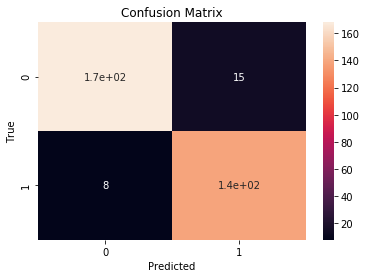

  ...
    to  
  ['...']
21/21 [==============================] - 6s 297ms/step - loss: 0.2062 - accuracy: 0.9247
Test Loss: 0.2062145537208943
Test Accuracy: 0.9247312


In [149]:
# Option 12

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)


for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=20
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 33 steps, validate for 9 steps
Epoch 1/5
33/33 [==============================] - 31s 954ms/step - loss: 0.4964 - accuracy: 0.7547 - val_loss: 0.3940 - val_accuracy: 0.8295
Epoch 2/5
33/33 [==============================] - 31s 947ms/step - loss: 0.3863 - accuracy: 0.8513 - val_loss: 0.3213 - val_accuracy: 0.8826
Epoch 3/5
33/33 [==============================] - 31s 941ms/step - loss: 0.3389 - accuracy: 0.8741 - val_loss: 0.3143 - val_accuracy: 0.8750
Epoch 4/5
33/33 [==============================] - 31s 941ms/step - loss: 0.3294 - accuracy: 0.8731 - val_loss: 0.3250 - val_accuracy: 0.8750
Epoch 5/5
33/33 [==============================] - 31s 945ms/step - loss: 0.3171 - accuracy: 0.8722 - val_loss: 0.3007 - val_accuracy: 0.8826
  ...
    to  
  ['...']
11/11 [==============================] - 6s 507ms/ste

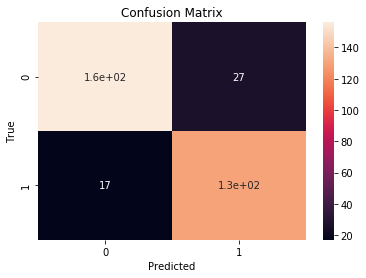

  ...
    to  
  ['...']
21/21 [==============================] - 6s 297ms/step - loss: 0.3331 - accuracy: 0.8771
Test Loss: 0.33311070253451663
Test Accuracy: 0.87711215


In [150]:
# Option 13

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)


for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 33 steps, validate for 9 steps
Epoch 1/10
33/33 [==============================] - 31s 948ms/step - loss: 0.5301 - accuracy: 0.7377 - val_loss: 0.4046 - val_accuracy: 0.8333
Epoch 2/10
33/33 [==============================] - 31s 943ms/step - loss: 0.3676 - accuracy: 0.8542 - val_loss: 0.3532 - val_accuracy: 0.8523
Epoch 3/10
33/33 [==============================] - 31s 938ms/step - loss: 0.3149 - accuracy: 0.8835 - val_loss: 0.3713 - val_accuracy: 0.8598
Epoch 4/10
33/33 [==============================] - 31s 941ms/step - loss: 0.3046 - accuracy: 0.8778 - val_loss: 0.3576 - val_accuracy: 0.8485
Epoch 5/10
33/33 [==============================] - 31s 936ms/step - loss: 0.3104 - accuracy: 0.8759 - val_loss: 0.3745 - val_accuracy: 0.8371
Epoch 6/10
33/33 [==============================] - 31s 947ms/step - loss

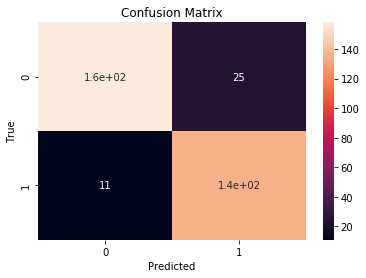

  ...
    to  
  ['...']
21/21 [==============================] - 6s 299ms/step - loss: 0.2719 - accuracy: 0.9002
Test Loss: 0.2718993751775651
Test Accuracy: 0.90015364


In [151]:
# Option 14

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)


for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 33 steps, validate for 9 steps
Epoch 1/20
33/33 [==============================] - 31s 951ms/step - loss: 0.4917 - accuracy: 0.7661 - val_loss: 0.3809 - val_accuracy: 0.8409
Epoch 2/20
33/33 [==============================] - 31s 943ms/step - loss: 0.3441 - accuracy: 0.8617 - val_loss: 0.3321 - val_accuracy: 0.8674
Epoch 3/20
33/33 [==============================] - 31s 946ms/step - loss: 0.3045 - accuracy: 0.8712 - val_loss: 0.2706 - val_accuracy: 0.8939
Epoch 4/20
33/33 [==============================] - 31s 938ms/step - loss: 0.3107 - accuracy: 0.8731 - val_loss: 0.2771 - val_accuracy: 0.8788
Epoch 5/20
33/33 [==============================] - 31s 942ms/step - loss: 0.3004 - accuracy: 0.8816 - val_loss: 0.3166 - val_accuracy: 0.8674
Epoch 6/20
33/33 [==============================] - 31s 942ms/step - loss

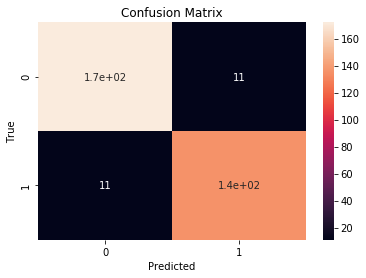

  ...
    to  
  ['...']
21/21 [==============================] - 6s 298ms/step - loss: 0.1879 - accuracy: 0.9309
Test Loss: 0.18792032237563813
Test Accuracy: 0.9308756


In [152]:
# Option 15

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)


for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=20
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 3 steps
Epoch 1/5
11/11 [==============================] - 31s 3s/step - loss: 0.6726 - accuracy: 0.6544 - val_loss: 0.5093 - val_accuracy: 0.7576
Epoch 2/5
11/11 [==============================] - 31s 3s/step - loss: 0.4387 - accuracy: 0.8078 - val_loss: 0.4732 - val_accuracy: 0.7841
Epoch 3/5
11/11 [==============================] - 31s 3s/step - loss: 0.3730 - accuracy: 0.8428 - val_loss: 0.4321 - val_accuracy: 0.8144
Epoch 4/5
11/11 [==============================] - 31s 3s/step - loss: 0.3617 - accuracy: 0.8485 - val_loss: 0.4755 - val_accuracy: 0.8220
Epoch 5/5
11/11 [==============================] - 31s 3s/step - loss: 0.3206 - accuracy: 0.8674 - val_loss: 0.3868 - val_accuracy: 0.8447
  ...
    to  
  ['...']
11/11 [==============================] - 5s 497ms/step - loss: 0.333

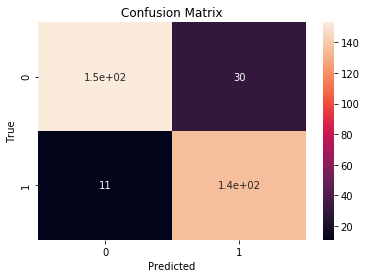

  ...
    to  
  ['...']
21/21 [==============================] - 6s 298ms/step - loss: 0.2885 - accuracy: 0.8833
Test Loss: 0.2884816474148205
Test Accuracy: 0.88325655


In [153]:
# Option 16

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)


for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 3 steps
Epoch 1/10
11/11 [==============================] - 31s 3s/step - loss: 0.8577 - accuracy: 0.5540 - val_loss: 0.4917 - val_accuracy: 0.7765
Epoch 2/10
11/11 [==============================] - 31s 3s/step - loss: 0.5181 - accuracy: 0.7557 - val_loss: 0.4438 - val_accuracy: 0.7917
Epoch 3/10
11/11 [==============================] - 31s 3s/step - loss: 0.4696 - accuracy: 0.7964 - val_loss: 0.3831 - val_accuracy: 0.8258
Epoch 4/10
11/11 [==============================] - 31s 3s/step - loss: 0.4298 - accuracy: 0.8220 - val_loss: 0.4199 - val_accuracy: 0.8068
Epoch 5/10
11/11 [==============================] - 31s 3s/step - loss: 0.4020 - accuracy: 0.8314 - val_loss: 0.3222 - val_accuracy: 0.8561
Epoch 6/10
11/11 [==============================] - 31s 3s/step - loss: 0.3977 - accurac

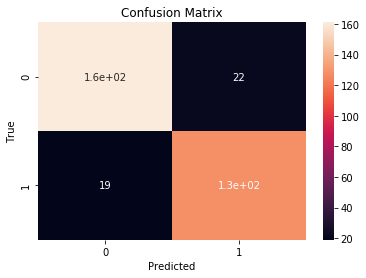

  ...
    to  
  ['...']
21/21 [==============================] - 6s 300ms/step - loss: 0.3564 - accuracy: 0.8495
Test Loss: 0.35640402351106915
Test Accuracy: 0.8494624


In [154]:
# Option 17

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)


for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 3 steps
Epoch 1/20
11/11 [==============================] - 31s 3s/step - loss: 0.6834 - accuracy: 0.6155 - val_loss: 0.4760 - val_accuracy: 0.7879
Epoch 2/20
11/11 [==============================] - 31s 3s/step - loss: 0.4157 - accuracy: 0.8116 - val_loss: 0.5201 - val_accuracy: 0.7727
Epoch 3/20
11/11 [==============================] - 31s 3s/step - loss: 0.3844 - accuracy: 0.8314 - val_loss: 0.3866 - val_accuracy: 0.8409
Epoch 4/20
11/11 [==============================] - 31s 3s/step - loss: 0.3353 - accuracy: 0.8551 - val_loss: 0.3746 - val_accuracy: 0.8485
Epoch 5/20
11/11 [==============================] - 31s 3s/step - loss: 0.3045 - accuracy: 0.8741 - val_loss: 0.3588 - val_accuracy: 0.8523
Epoch 6/20
11/11 [==============================] - 31s 3s/step - loss: 0.2933 - accurac

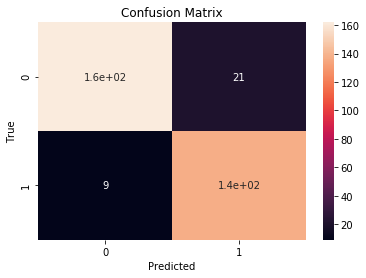

  ...
    to  
  ['...']
21/21 [==============================] - 6s 302ms/step - loss: 0.2263 - accuracy: 0.9232
Test Loss: 0.22626814175219762
Test Accuracy: 0.92319506


In [155]:
# Option 18

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)


for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=20
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 33 steps, validate for 9 steps
Epoch 1/5
33/33 [==============================] - 32s 956ms/step - loss: 0.6135 - accuracy: 0.7093 - val_loss: 0.3693 - val_accuracy: 0.8447
Epoch 2/5
33/33 [==============================] - 31s 940ms/step - loss: 0.3697 - accuracy: 0.8608 - val_loss: 0.4932 - val_accuracy: 0.7917
Epoch 3/5
33/33 [==============================] - 31s 944ms/step - loss: 0.3371 - accuracy: 0.8684 - val_loss: 0.2948 - val_accuracy: 0.8561
Epoch 4/5
33/33 [==============================] - 31s 949ms/step - loss: 0.3185 - accuracy: 0.8769 - val_loss: 0.2869 - val_accuracy: 0.8750
Epoch 5/5
33/33 [==============================] - 31s 946ms/step - loss: 0.3143 - accuracy: 0.8797 - val_loss: 0.2844 - val_accuracy: 0.8750
  ...
    to  
  ['...']
11/11 [==============================] - 5s 496ms/ste

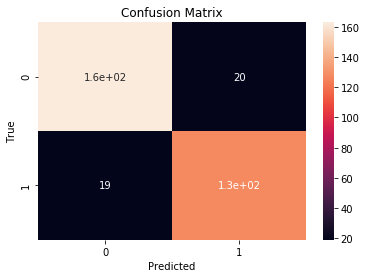

  ...
    to  
  ['...']
21/21 [==============================] - 6s 300ms/step - loss: 0.3667 - accuracy: 0.8602
Test Loss: 0.36666289291211535
Test Accuracy: 0.86021507


In [156]:
# Option 19

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)


for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 33 steps, validate for 9 steps
Epoch 1/10
33/33 [==============================] - 31s 951ms/step - loss: 0.5650 - accuracy: 0.7121 - val_loss: 0.4161 - val_accuracy: 0.8030
Epoch 2/10
33/33 [==============================] - 31s 954ms/step - loss: 0.3754 - accuracy: 0.8381 - val_loss: 0.3715 - val_accuracy: 0.8447
Epoch 3/10
33/33 [==============================] - 31s 939ms/step - loss: 0.3208 - accuracy: 0.8627 - val_loss: 0.4127 - val_accuracy: 0.8030
Epoch 4/10
33/33 [==============================] - 31s 938ms/step - loss: 0.3020 - accuracy: 0.8788 - val_loss: 0.4834 - val_accuracy: 0.7879
Epoch 5/10
33/33 [==============================] - 31s 940ms/step - loss: 0.3082 - accuracy: 0.8788 - val_loss: 0.3472 - val_accuracy: 0.8409
Epoch 6/10
33/33 [==============================] - 31s 946ms/step - loss

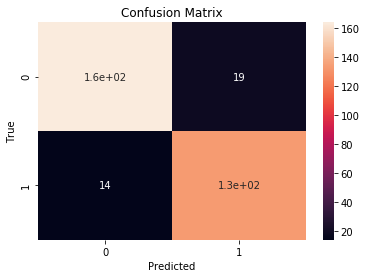

  ...
    to  
  ['...']
21/21 [==============================] - 6s 296ms/step - loss: 0.2904 - accuracy: 0.8817
Test Loss: 0.2903633557614826
Test Accuracy: 0.8817204


In [157]:
# Option 20

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)


for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 33 steps, validate for 9 steps
Epoch 1/20
33/33 [==============================] - 31s 951ms/step - loss: 0.5302 - accuracy: 0.7472 - val_loss: 0.3253 - val_accuracy: 0.8333
Epoch 2/20
33/33 [==============================] - 31s 943ms/step - loss: 0.3589 - accuracy: 0.8636 - val_loss: 0.3143 - val_accuracy: 0.8788
Epoch 3/20
33/33 [==============================] - 31s 945ms/step - loss: 0.3283 - accuracy: 0.8627 - val_loss: 0.3185 - val_accuracy: 0.8750
Epoch 4/20
33/33 [==============================] - 31s 941ms/step - loss: 0.3146 - accuracy: 0.8684 - val_loss: 0.2739 - val_accuracy: 0.8977
Epoch 5/20
33/33 [==============================] - 31s 945ms/step - loss: 0.2913 - accuracy: 0.8902 - val_loss: 0.2831 - val_accuracy: 0.8977
Epoch 6/20
33/33 [==============================] - 31s 939ms/step - loss

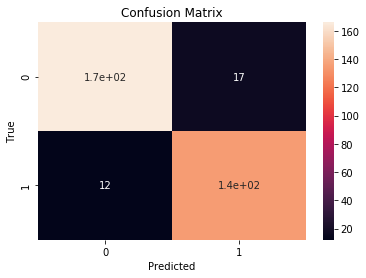

  ...
    to  
  ['...']
21/21 [==============================] - 6s 298ms/step - loss: 0.2007 - accuracy: 0.9078
Test Loss: 0.20071448066404887
Test Accuracy: 0.9078341


In [158]:
# Option 21

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)


for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=20
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 3 steps
Epoch 1/5
11/11 [==============================] - 32s 3s/step - loss: 0.7359 - accuracy: 0.6316 - val_loss: 0.5173 - val_accuracy: 0.7614
Epoch 2/5
11/11 [==============================] - 32s 3s/step - loss: 0.4066 - accuracy: 0.8277 - val_loss: 0.4410 - val_accuracy: 0.8068
Epoch 3/5
11/11 [==============================] - 31s 3s/step - loss: 0.3583 - accuracy: 0.8580 - val_loss: 0.4798 - val_accuracy: 0.7727
Epoch 4/5
11/11 [==============================] - 32s 3s/step - loss: 0.3149 - accuracy: 0.8741 - val_loss: 0.3712 - val_accuracy: 0.8371
Epoch 5/5
11/11 [==============================] - 31s 3s/step - loss: 0.2960 - accuracy: 0.8797 - val_loss: 0.3140 - val_accuracy: 0.8750
  ...
    to  
  ['...']
11/11 [==============================] - 5s 497ms/step - loss: 0.277

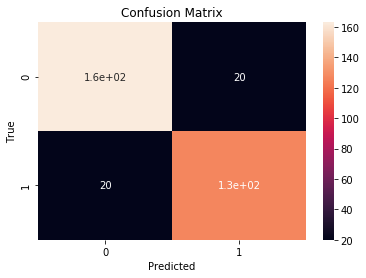

  ...
    to  
  ['...']
21/21 [==============================] - 6s 298ms/step - loss: 0.3683 - accuracy: 0.8479
Test Loss: 0.36830227963981177
Test Accuracy: 0.84792626


In [159]:
# Option 22

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)


for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=5
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 3 steps
Epoch 1/10
11/11 [==============================] - 32s 3s/step - loss: 0.9126 - accuracy: 0.5398 - val_loss: 0.5645 - val_accuracy: 0.7348
Epoch 2/10
11/11 [==============================] - 34s 3s/step - loss: 0.4995 - accuracy: 0.7699 - val_loss: 0.3714 - val_accuracy: 0.8409
Epoch 3/10
11/11 [==============================] - 32s 3s/step - loss: 0.4416 - accuracy: 0.8210 - val_loss: 0.4240 - val_accuracy: 0.8030
Epoch 4/10
11/11 [==============================] - 31s 3s/step - loss: 0.4128 - accuracy: 0.8400 - val_loss: 0.3936 - val_accuracy: 0.8295
Epoch 5/10
11/11 [==============================] - 31s 3s/step - loss: 0.3461 - accuracy: 0.8532 - val_loss: 0.2745 - val_accuracy: 0.8864
Epoch 6/10
11/11 [==============================] - 31s 3s/step - loss: 0.3246 - accurac

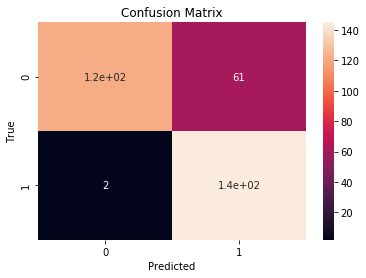

  ...
    to  
  ['...']
21/21 [==============================] - 6s 297ms/step - loss: 0.2612 - accuracy: 0.8909
Test Loss: 0.26116562439572244
Test Accuracy: 0.89093703


In [160]:
# Option 23

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)


for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=10
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 3 steps
Epoch 1/20
11/11 [==============================] - 32s 3s/step - loss: 0.8326 - accuracy: 0.6080 - val_loss: 0.5248 - val_accuracy: 0.7197
Epoch 2/20
11/11 [==============================] - 32s 3s/step - loss: 0.4818 - accuracy: 0.7860 - val_loss: 0.4838 - val_accuracy: 0.7803
Epoch 3/20
11/11 [==============================] - 31s 3s/step - loss: 0.4195 - accuracy: 0.8191 - val_loss: 0.3999 - val_accuracy: 0.8220
Epoch 4/20
11/11 [==============================] - 31s 3s/step - loss: 0.3609 - accuracy: 0.8447 - val_loss: 0.3514 - val_accuracy: 0.8447
Epoch 5/20
11/11 [==============================] - 31s 3s/step - loss: 0.3280 - accuracy: 0.8523 - val_loss: 0.3632 - val_accuracy: 0.8523
Epoch 6/20
11/11 [==============================] - 31s 3s/step - loss: 0.2905 - accurac

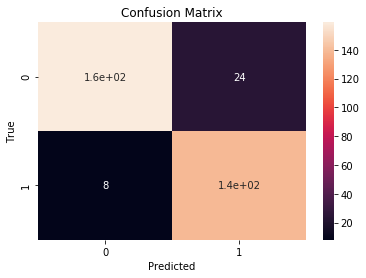

  ...
    to  
  ['...']
21/21 [==============================] - 6s 298ms/step - loss: 0.2230 - accuracy: 0.9247
Test Loss: 0.22302222588942164
Test Accuracy: 0.9247312


In [161]:
# Option 24

# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)


for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  if num_model == 2:
    break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 100,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=20
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  #model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()


# 3.3. Robustness check

Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 33 steps, validate for 9 steps
Epoch 1/20
33/33 [==============================] - 31s 951ms/step - loss: 0.7540 - accuracy: 0.6771 - val_loss: 0.3996 - val_accuracy: 0.8598
Epoch 2/20
33/33 [==============================] - 31s 943ms/step - loss: 0.3948 - accuracy: 0.8295 - val_loss: 0.3030 - val_accuracy: 0.8636
Epoch 3/20
33/33 [==============================] - 31s 950ms/step - loss: 0.3358 - accuracy: 0.8617 - val_loss: 0.2553 - val_accuracy: 0.8902
Epoch 4/20
33/33 [==============================] - 31s 938ms/step - loss: 0.3090 - accuracy: 0.8769 - val_loss: 0.2771 - val_accuracy: 0.8674
Epoch 5/20
33/33 [==============================] - 31s 940ms/step - loss: 0.2988 - accuracy: 0.8731 - val_loss: 0.2829 - val_accuracy: 0.8902
Epoch 6/20
33/33 [==============================] - 31s 937ms/step - loss

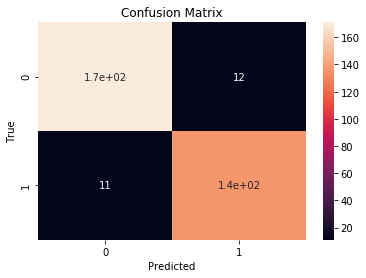

  ...
    to  
  ['...']
21/21 [==============================] - 6s 296ms/step - loss: 0.1778 - accuracy: 0.9386
Test Loss: 0.17784039640710467
Test Accuracy: 0.9385561
Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 33 steps, validate for 9 steps
Epoch 1/20
33/33 [==============================] - 32s 955ms/step - loss: 0.4896 - accuracy: 0.7765 - val_loss: 0.4124 - val_accuracy: 0.8636
Epoch 2/20
33/33 [==============================] - 31s 941ms/step - loss: 0.3297 - accuracy: 0.8665 - val_loss: 0.3922 - val_accuracy: 0.8674
Epoch 3/20
33/33 [==============================] - 31s 939ms/step - loss: 0.3136 - accuracy: 0.8769 - val_loss: 0.4848 - val_accuracy: 0.8371
Epoch 4/20
33/33 [==============================] - 31s 940ms/step - loss: 0.2955 - accuracy: 0.8826 - val_loss: 0.2773 - val_accuracy: 0.8977
Epoch 5/20
33/33 [============================

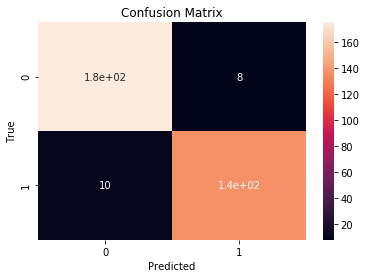

  ...
    to  
  ['...']
21/21 [==============================] - 6s 299ms/step - loss: 0.1945 - accuracy: 0.9293
Test Loss: 0.19450055701392038
Test Accuracy: 0.92933947
Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 33 steps, validate for 9 steps
Epoch 1/20
33/33 [==============================] - 31s 951ms/step - loss: 0.5135 - accuracy: 0.7784 - val_loss: 0.3750 - val_accuracy: 0.8447
Epoch 2/20
33/33 [==============================] - 31s 948ms/step - loss: 0.3543 - accuracy: 0.8542 - val_loss: 0.3373 - val_accuracy: 0.8371
Epoch 3/20
33/33 [==============================] - 31s 946ms/step - loss: 0.3084 - accuracy: 0.8816 - val_loss: 0.3562 - val_accuracy: 0.8447
Epoch 4/20
33/33 [==============================] - 31s 944ms/step - loss: 0.2911 - accuracy: 0.8759 - val_loss: 0.2928 - val_accuracy: 0.8712
Epoch 5/20
33/33 [===========================

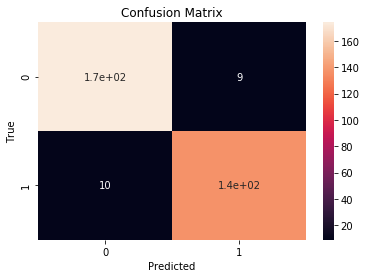

  ...
    to  
  ['...']
21/21 [==============================] - 6s 300ms/step - loss: 0.1777 - accuracy: 0.9355
Test Loss: 0.17767609691336042
Test Accuracy: 0.9354839
Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 33 steps, validate for 9 steps
Epoch 1/20
33/33 [==============================] - 31s 953ms/step - loss: 0.5681 - accuracy: 0.7083 - val_loss: 0.3502 - val_accuracy: 0.8333
Epoch 2/20
33/33 [==============================] - 31s 945ms/step - loss: 0.4183 - accuracy: 0.8229 - val_loss: 0.3157 - val_accuracy: 0.8636
Epoch 3/20
33/33 [==============================] - 31s 943ms/step - loss: 0.3595 - accuracy: 0.8542 - val_loss: 0.2612 - val_accuracy: 0.9053
Epoch 4/20
33/33 [==============================] - 31s 944ms/step - loss: 0.3484 - accuracy: 0.8532 - val_loss: 0.2721 - val_accuracy: 0.8939
Epoch 5/20
33/33 [============================

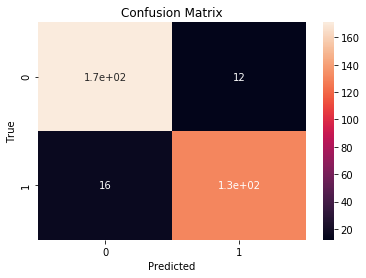

  ...
    to  
  ['...']
21/21 [==============================] - 6s 299ms/step - loss: 0.2221 - accuracy: 0.9201
Test Loss: 0.22206124734310878
Test Accuracy: 0.92012286
Found 1056 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 33 steps, validate for 9 steps
Epoch 1/20
33/33 [==============================] - 31s 951ms/step - loss: 0.6498 - accuracy: 0.6932 - val_loss: 0.4324 - val_accuracy: 0.8068
Epoch 2/20
33/33 [==============================] - 31s 944ms/step - loss: 0.3648 - accuracy: 0.8447 - val_loss: 0.4805 - val_accuracy: 0.8030
Epoch 3/20
33/33 [==============================] - 32s 957ms/step - loss: 0.3343 - accuracy: 0.8665 - val_loss: 0.3448 - val_accuracy: 0.8598
Epoch 4/20
33/33 [==============================] - 31s 945ms/step - loss: 0.3202 - accuracy: 0.8589 - val_loss: 0.3149 - val_accuracy: 0.8712
Epoch 5/20
33/33 [===========================

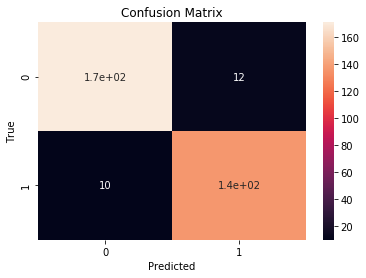

  ...
    to  
  ['...']
21/21 [==============================] - 6s 298ms/step - loss: 0.1780 - accuracy: 0.9309
Test Loss: 0.17800197253624597
Test Accuracy: 0.9308756


In [162]:
# for K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

val_accs_res = []
val_losses_res = []

test_accs_res = []
test_losses_res = []

num_model = 1

# ImageDataGenerator with data augmentation
datagen = image.ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True)
  
datagen_val = image.ImageDataGenerator(rescale = 1./255)

for train_index, val_index in skf.split(train_com, train_com['label']):

  # for time efficiency, we train only once now
  #if num_model == 2:
  #  break

  train_data = train_com.iloc[train_index]
  val_data = train_com.iloc[val_index]

  train_ds = datagen.flow_from_dataframe(
      dataframe = train_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode = "rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  val_ds = datagen_val.flow_from_dataframe(
      dataframe = val_data,
      x_col = "path",
      y_col = "label",
      target_size = (250, 250),
      color_mode ="rgb",
      class_mode = "binary",
      batch_size = 32,
      shuffle = True,
      seed = 1)

  # create the model
  # own model

  num_classes = 2

  # model structure
  model = Sequential([
    Input(shape=(250,250,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid') # we have only 2 classes. therefore, we need sigmoid(0~1 value) instead of softmax.
    # unit must be 1 instead of num_classes in this case, because there is only one number in the result of sigmoid function with binary classification.
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  #model.summary()

  # Create callbacks
  checkpoint_path = 'C:/Users/server/Desktop/own_model/weights/' + str(num_model) + '.ckpt'
  modelcheckpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

  # Learning rate scheduler
  reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, verbose=1)
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

  #time_callback = TimeHistory()
  
  callbacks_list = [modelcheckpoint, earlystopping, reduce_lr]

  # train the model
  epochs=20
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list
  )

  #times = time_callback.times
  #print(times)

  model.load_weights(checkpoint_path)
  #model_path = 'C:/Users/server/Desktop/own_model/models/' + str(num_model) + '.h5'
  #model.save(model_path)

  num_model += 1

  val_accs_own.append(history.history['val_accuracy'])
  val_losses_own.append(history.history['val_loss'])

  # evaluate model with test dataset

  score = model.evaluate(test_ds_new)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds_new)
  y_pred = np.round(y_pred)

  print(classification_report(y_test_new, y_pred))

  plt.figure(figsize = (6, 4))

  sns.heatmap(confusion_matrix(y_test_new, y_pred),annot = True)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  score = model.evaluate(test_ds)

  print("Test Loss:", score[0])
  print("Test Accuracy:", score[1])

  test_accs_res.append(score[1])
  test_losses_res.append(score[0])

  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)

  tf.keras.backend.clear_session()
